In [ ]:
!pip install av
!pip install --upgrade albumentations
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import av
import albumentations as A
from fastai.vision.all import *

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
def seed_everything (seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    set_seed(random_seed, reproducible=True)


# Parámetros de pre-procesado

In [ ]:
# aplicar ajuste contraste True / False
use_bcet = False

# oversampling de clases minoritarias 0-30 (3) / 40-50 (4)
oversampling_min = 0 # numero de videos total por franja que queremos obtener
# con 0 no hay oversampling, para hacer oversampling, usar 150 / 200 / 250 / 300



# 1. Extraer frames

In [ ]:
# descargamos los datos
!gdown XXXXXxXxxxxXXxxXx


In [ ]:
# descomprimimos el zip
!unzip -qq data.zip -d tfm-data

mapname:  conversion of  failed


In [ ]:
# vamos a trabajar en el directorio en el que están los datos
%cd ./tfm-data

/content/tfm-data


In [ ]:
# usamos Path para acceder más fácilmente
data_path = Path('./videos')
data_path.ls()

(#1480) [Path('videos/0X2EC98D548B0A3542.avi'),Path('videos/0X3FD37EEEABBE989D.avi'),Path('videos/0X2D1062571172E8A7.avi'),Path('videos/0X1E0132313BE50536.avi'),Path('videos/0X2A67800D05897E40.avi'),Path('videos/0X2C7D0289D4D9C8DA.avi'),Path('videos/0X3CC86A7AC66865CC.avi'),Path('videos/0X3A78E8C699486EDF.avi'),Path('videos/0X3B0EFA9B23EC8818.avi'),Path('videos/0X3C207E8489AD5BAE.avi')...]

In [ ]:
# con get_files obtenemos referencias a los ficheros de los videos
video_paths = get_files(data_path, extensions='.avi')
video_paths[0:4]

(#4) [Path('videos/0X2EC98D548B0A3542.avi'),Path('videos/0X3FD37EEEABBE989D.avi'),Path('videos/0X2D1062571172E8A7.avi'),Path('videos/0X1E0132313BE50536.avi')]

In [ ]:
video_paths[0]

Path('videos/0X2EC98D548B0A3542.avi')

In [ ]:
#!rm -r /content/tfm-data/frames

In [ ]:
# creamos un nuevo directorio para las frames
path_frames = Path('/content/tfm-data')/'frames'
if not path_frames.exists(): path_frames.mkdir()

In [ ]:
path_frames

Path('/content/tfm-data/frames')

In [ ]:
video_path = video_paths[0]
video_path.stem

'0X2EC98D548B0A3542'

In [ ]:
def extract_diff_frames(video_path, max_frames=125, lag_ms=100, thresh=10):
  cap = cv2.VideoCapture(str(video_path))

  if not cap.isOpened():
      print("Error opening video file")

  fps = cap.get(cv2.CAP_PROP_FPS)
  lag = int(lag_ms * fps // 1000)

  frames = []
  diff_frames = []
  frame_idx = -1

  while frame_idx < (max_frames + lag):
    ret, frame = cap.read()
    if not ret:
        break

    # extraer frame y generar mascara
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(frame.copy())
    frame_idx += 1

    if frame_idx < lag:
      # necesitamos al menos lag frames para empezar
      continue

    # print(f"idx: {frame_idx}")
    # calculamos diferencia de frame_idx con lag
    diff_frame = cv2.absdiff(frames[frame_idx - lag], frame)
    # creamos una mascara para mostrar cambios por encima del umbral
    diff_frame = cv2.threshold(src=diff_frame, thresh=thresh, maxval=255, type=cv2.THRESH_BINARY)[1]
    diff_frames.append(diff_frame.copy())

  return diff_frames


In [ ]:
def avi2frames(video_path, path_frames=path_frames, start_frame=0, max_frames=100, lag_ms=100, thresh=15):
    dest_path = path_frames/video_path.stem
    dest_path.mkdir(parents=True, exist_ok=True)

    frames = extract_diff_frames(video_path, max_frames=(start_frame + max_frames), lag_ms=lag_ms, thresh=thresh)
    for i, frame in enumerate(frames[start_frame:(start_frame + max_frames)]):
        cv2.imwrite(str(dest_path/f'{i}.png'), frame)

In [ ]:
# probamos que funciona correctamente
avi2frames(video_paths[50], start_frame=0, max_frames=100, thresh=15, lag_ms=80)
len(path_frames.ls()[0].ls())

100

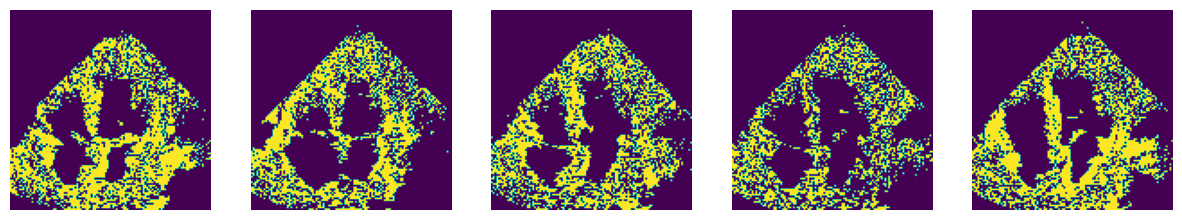

In [ ]:
show_images([Image.open(img) for img in path_frames.ls()[0].ls()[0:30:7]])

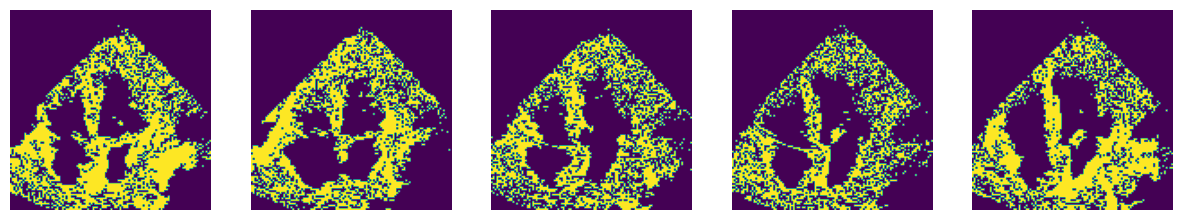

In [ ]:
# probamos que funciona correctamente
avi2frames(video_paths[50], start_frame=0, max_frames=80, thresh=15, lag_ms=120)
show_images([Image.open(img) for img in path_frames.ls()[0].ls()[0:30:7]])

In [ ]:
# borramos el ejemplo que hemos generado, antes de extraer las imágenes para todos los videos
!rm -r /content/tfm-data/frames


In [ ]:
# ejecutamos para todas las frames
parallel(avi2frames, video_paths, start_frame=0, max_frames=120)

(#1480) [None,None,None,None,None,None,None,None,None,None...]

In [ ]:
# comprobamos que se han creado frames para los 1480 videos
len(path_frames.ls())

1480

In [ ]:
# comprobamos que se han extraido las frames que queriasmos
len(path_frames.ls()[0].ls())

120

In [ ]:
# definimos una función que devuelva las frames ordenadas
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

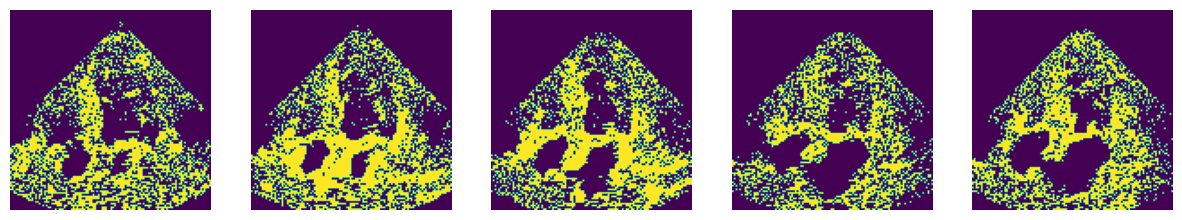

In [ ]:
# comprobamos que las imágenes se ven correctamente
show_images([Image.open(img) for img in path_frames.ls()[0].ls_sorted()[0:25:5]])

# 2. Generar splits

In [ ]:
# cargamos el dataset con el FEVI por cada video
df = pd.read_csv('target.csv')
df.head()

,FileName,FEVI
0,0X1A030EFDD45062FA,44.485700
1,0X1A05829AEDF6C65,64.078050
2,0X1A05DFFFCAFB253B,65.143601
3,0X1A09BE7969DA1508,69.566347
4,0X1A0A263B22CCD966,65.454529


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  1480 non-null   object 
 1   FEVI      1480 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.2+ KB


In [ ]:
df['target'] = df['FEVI'] / 100
df.head()

,FileName,FEVI,target
0,0X1A030EFDD45062FA,44.485700,0.444857
1,0X1A05829AEDF6C65,64.078050,0.640781
2,0X1A05DFFFCAFB253B,65.143601,0.651436
3,0X1A09BE7969DA1508,69.566347,0.695663
4,0X1A0A263B22CCD966,65.454529,0.654545


In [ ]:
df['FEVI10'] = df['FEVI'] // 10
df['FEVI10'].value_counts()

6.0    632
5.0    466
4.0    134
3.0     93
2.0     82
7.0     49
1.0     17
8.0      4
0.0      3
Name: FEVI10, dtype: int64

In [ ]:
# juntamos las franjas 0/1/2/3,
df.loc[df['FEVI10'] == 0, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 2, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 1, 'FEVI10'] = 3

# juntamos también 6/7/8 porque
df.loc[df['FEVI10'] == 8, 'FEVI10'] = 6
df.loc[df['FEVI10'] == 7, 'FEVI10'] = 6

df['FEVI10'].value_counts()

6.0    685
5.0    466
3.0    195
4.0    134
Name: FEVI10, dtype: int64

In [ ]:
split_counts = df['FEVI10'].value_counts() // 10
split_counts

6.0    68
5.0    46
3.0    19
4.0    13
Name: FEVI10, dtype: int64

In [ ]:
list(split_counts.items())

[(6.0, 68), (5.0, 46), (3.0, 19), (4.0, 13)]

In [ ]:
sum(split_counts)

146

In [ ]:
random_seed=12
seed_everything(random_seed)

In [ ]:
# creamos el split de test
test_idx = np.array([])
for k, count in list(split_counts.items()):
  test_idx = np.concatenate([test_idx, df[df['FEVI10'] == k].sample(count, random_state=random_seed).index], axis=0)

test_df = df.iloc[test_idx].sample(frac=1, random_state=random_seed).reset_index(drop=True)
test_df['FEVI10'].value_counts()

6.0    68
5.0    46
3.0    19
4.0    13
Name: FEVI10, dtype: int64

In [ ]:
# generamos train, sacando las filas que hemos dejado para test
train_df = df[~df.index.isin(test_idx)].sample(frac=1, random_state=random_seed).reset_index(drop=True)
train_df.shape

(1334, 4)

In [ ]:
valid_idx = np.array([])
for k, count in list(split_counts.items()):
  valid_idx = np.concatenate([valid_idx, train_df[train_df['FEVI10'] == k].sample(count, random_state=random_seed).index], axis=0)

splits = IndexSplitter(valid_idx)

In [ ]:
train_df.iloc[valid_idx]['FEVI10'].value_counts()

6.0    68
5.0    46
3.0    19
4.0    13
Name: FEVI10, dtype: int64

In [ ]:
train_df[~train_df.index.isin(valid_idx)]['FEVI10'].value_counts()


6.0    549
5.0    374
3.0    157
4.0    108
Name: FEVI10, dtype: int64

In [ ]:
len(test_idx) + len(valid_idx) + len(train_df[~train_df.index.isin(valid_idx)])

1480

# 3. Oversampling

In [ ]:
if oversampling_min > 0:
  # vamos a hacer oversampling, generando nuevos videos
  # solo a partir de datos de train, por eso excluimos valid
  tr_df = train_df[~train_df.index.isin(valid_idx)]
  counts = tr_df['FEVI10'].value_counts()
  print(counts)


In [ ]:
if oversampling_min > 0:

  # Definimos las transformaciones que vamos a aplicar al replicar las frames
  transform = A.Compose([
      # A.RandomBrightnessContrast(brightness_limit=(-0.03,0.06), contrast_limit=(-0.03,0.06), p=1),
      #A.OneOf([
      #  A.MedianBlur(blur_limit=(3,3), p=0.5),
      #  A.GaussNoise(p=0.5),
      #], p=0.25),
      A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.01, rotate_limit=3, border_mode=cv2.BORDER_CONSTANT, p=1),
  ])

  new_df = pd.DataFrame()
  tot_img = 0
  seed_everything(random_seed)

  # número de imágenes que queremos por cada franja de FEVI10
  num_img = oversampling_min

  for k, img_count in counts.items():
      if img_count >= num_img:
          continue
      tmp_df = tr_df[tr_df['FEVI10'] == k].reset_index(drop=True)
      # cuantos nuevos videos vamos a generar para cada subclase
      num_new = num_img - img_count
      idx = 0

      print(f"Generating {num_new} videos for class {k}")

      while num_new > 0:
        row = tmp_df.iloc[idx]
        video_id = row['FileName']
        new_video_id = f"{video_id}_{new_df.shape[0]}"
        # creamos directorio para el nuevo video
        video_path = path_frames/new_video_id
        if not video_path.exists(): video_path.mkdir()

        print(f"Generating new video {new_video_id} / idx {idx} / class {k}")
        data = None
        for img_path in (path_frames/video_id).ls_sorted():
          new_img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
          # aplicamos una transformacion
          data = transform(image=new_img)
          new_img = data['image']
          new_img_path = (video_path/img_path.stem).with_suffix('.png')

          if not cv2.imwrite(str(new_img_path), new_img):
              print(f"error writing file {new_img_path}")
              break

        new_df = new_df.append({'FileName': new_video_id, 'target': row['target'], 'FEVI10': k }, ignore_index=True)
        # indice del siguiente video
        idx = (idx + 1) % img_count
        # actualizamos numero de videos restantes
        num_new -= 1

  # ahora tenemos que juntar el DF con los nuevos videos con el que teniamos ya con train + valid
  valid_filenames = train_df.iloc[valid_idx]['FileName'].values

  # primero guardar referencias de valid
  new_valid_idx = train_df[train_df['FileName'].isin(valid_filenames)].index
  train_df.iloc[new_valid_idx]['FEVI10'].value_counts()

  # ahora concatenamos el nuevo df con train
  train_df = pd.concat([train_df, new_df], axis=0).sample(frac=1, random_state=random_seed).reset_index(drop=True)

  # y ahora volvemos a recuperar los idx de valid
  train_df[train_df['FileName'].isin(valid_filenames)]['FEVI10'].value_counts()

  new_valid_idx = train_df[train_df['FileName'].isin(valid_filenames)].index
  train_df.iloc[new_valid_idx]['FEVI10'].value_counts()
  splits = IndexSplitter(new_valid_idx)

  print(train_df[~train_df.index.isin(new_valid_idx)]['FEVI10'].value_counts())

# 4. Definir modelo

In [ ]:
class RegressionModel(Module):
    def __init__(self, model_arch):
        model = model_arch(pretrained=True)
        self.encoder = TimeDistributed(create_body(model))
        self.head = TimeDistributed(create_head(model.fc.in_features, 1))

    def forward(self, x):
        x = torch.stack(x, dim=1)
        return self.head(self.encoder(x)).mean(dim=1)

def simple_splitter(model): return [params(model.encoder), params(model.head)]

In [ ]:
class CNNLSTM_Regresion(Module):
    def __init__(self, model_arch, dropout=0.5):
        self.resnet = model_arch(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1], nn.Flatten())
        self.encoder = TimeDistributed(self.resnet)
        self.lstm = nn.LSTM(input_size=512, hidden_size=512, num_layers=4, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(4 * 512, 512)
        self.fc2 = nn.Linear(512, 1)  # Capa de salida para regresión, con una sola unidad

    def forward(self, x):
        x = torch.stack(x, dim=1)
        enc_out = self.encoder(x)
        lstm_out, (hidden, _) = self.lstm(enc_out)
        batch_size = x.shape[0]
        out = hidden.permute(1, 0, 2).contiguous().view(batch_size, -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = F.mish(out)
        out = self.fc2(out)  # Salida con una sola unidad para regresión
        return out

def simple_splitter(model):
    return [params(model.encoder), params(model.lstm) + params(model.fc1) + params(model.fc2)]

In [ ]:
# esta clase nos permite manejar un conjunto de imágenes como una tupla
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs):
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

# esta clase obtiene las frames de un video y las devuelve en forma de tupla
class ImageTupleTfm(Transform):
    def __init__(self, start_frame=0, seq_len=20):
        store_attr()

    def encodes(self, path: Path):
        frames = path.ls_sorted()
        n_frames = len(frames)

        # nos quedamos con max_frames, empezando en start_frame
        if n_frames < (self.start_frame + self.seq_len):
          self.start_frame = max(0, n_frames - self.seq_len)

        # si no tenemos suficientes frames, replicamos
        if n_frames < self.seq_len:
          new_frames = self.seq_len - n_frames
          for n in range(0, new_frames):
            frames.append(frames[n % n_frames])

        s = slice(self.start_frame, self.start_frame + self.seq_len)
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
# Esta función le dice al dataset donde buscar las X (frames de los videos)
def get_x(row): return path_frames/row['FileName']
# Y esta le dice donde buscar la Y, el target de cada X
def get_y(row): return row['target']

In [ ]:
video_frames_path = path_frames.ls()[10]
len(video_frames_path.ls_sorted())

120

In [ ]:
# comprobamos que funciona, deberia darnos 120 frames
tpl = ImageTupleTfm(seq_len=120, start_frame=30)
len(tpl(video_frames_path))

120

# Training loop

In [ ]:
# Definimos el grid de parametros
start_frame=[0, 5, 10, 15, 20, 25, 30]
seq_len=[20, 30, 40, 50] # 60

batch_augmentation = False  # False / True
shuffle_batch = True

# arquitectura de modelo que vamos a usar
model_arch = resnet34

# No modificar epochs,
epochs_freeze = 20 # vamos a entrenar solo 20 sin unfreeze

# batch size
bs = 8

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import gc
import time

In [ ]:
results = pd.DataFrame()

In [ ]:
if not Path('/content/gdrive/MyDrive/TFM').exists(): Path('/content/gdrive/MyDrive/TFM').mkdir()
if not Path('/content/gdrive/MyDrive/TFM/pruebas').exists(): Path('/content/gdrive/MyDrive/TFM/pruebas').mkdir()



[2023-08-06 18:45] start_frame: 0; seq_len: 20;


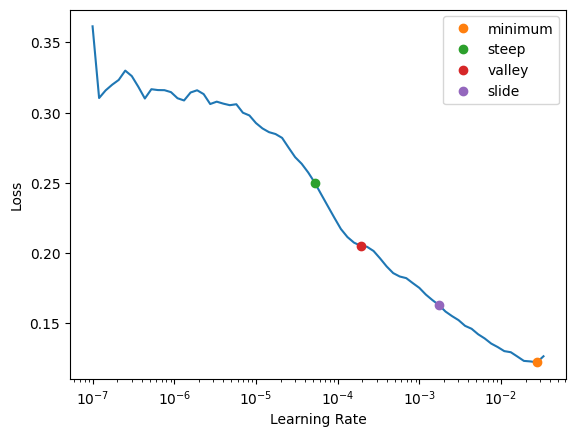

LR: 0.00019054606673307717


epoch,train_loss,valid_loss,mae,mse,time
0,0.024742,0.011506,0.080764,0.011506,00:26
1,0.011330,0.010211,0.080654,0.010211,00:25
2,0.011047,0.011789,0.088237,0.011789,00:27
3,0.010273,0.008760,0.073911,0.008760,00:26
4,0.010623,0.011459,0.079812,0.011459,00:26
5,0.010626,0.008720,0.065360,0.008720,00:26
6,0.007394,0.007580,0.065426,0.007580,00:26
7,0.005631,0.015112,0.098293,0.015112,00:26
8,0.004430,0.008686,0.074159,0.008686,00:26
9,0.003407,0.009218,0.074135,0.009218,00:26


Better model found at epoch 0 with mse value: 0.011506251059472561.
Better model found at epoch 1 with mse value: 0.010211159475147724.
Better model found at epoch 3 with mse value: 0.008759964257478714.
Better model found at epoch 5 with mse value: 0.008719980716705322.
Better model found at epoch 6 with mse value: 0.007580338977277279.
Better model found at epoch 12 with mse value: 0.006846838165074587.
Better model found at epoch 13 with mse value: 0.006371023133397102.
Better model found at epoch 14 with mse value: 0.006208848673850298.
Better model found at epoch 15 with mse value: 0.005996325984597206.


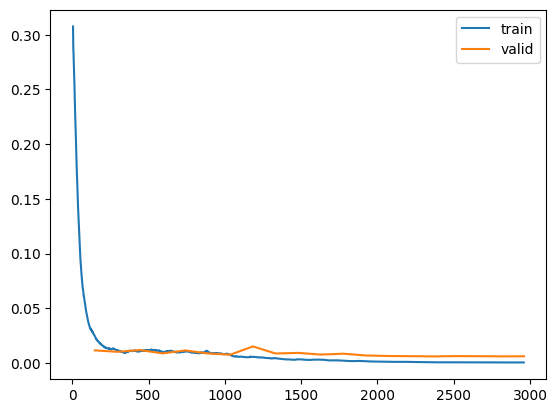

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000191           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0            0       20   0.060443   0.005996  0.071437  0.010393  9.31  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.100525
4.0    0.097944
5.0    0.045805
6.0    0.051976
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.179728
4.0    0.096395
5.0    0.040722
6.0    0.057185
Name: error, dtype: float64


[2023-08-06 18:55] start_frame: 0; seq_len: 30;


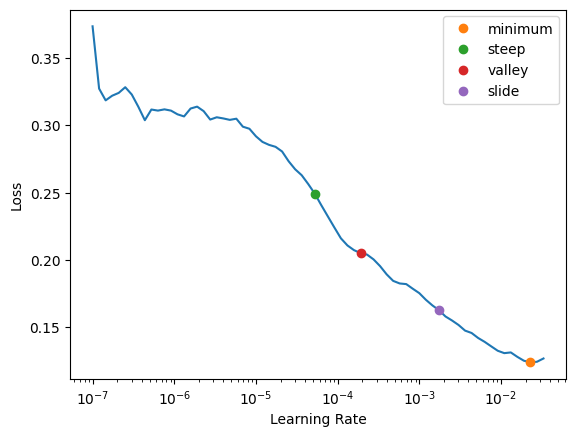

LR: 0.00019054606673307717


epoch,train_loss,valid_loss,mae,mse,time
0,0.025757,0.014978,0.092066,0.014978,00:36
1,0.012363,0.013930,0.090202,0.013930,00:36
2,0.011826,0.010705,0.076074,0.010705,00:35
3,0.011388,0.017667,0.100457,0.017667,00:36
4,0.010524,0.008443,0.067937,0.008443,00:35
5,0.010928,0.039856,0.162060,0.039856,00:36
6,0.007478,0.011596,0.077819,0.011596,00:36
7,0.005153,0.011217,0.077042,0.011217,00:36
8,0.004010,0.009856,0.073253,0.009856,00:35
9,0.003970,0.011590,0.078637,0.011590,00:36


Better model found at epoch 0 with mse value: 0.014977574348449707.
Better model found at epoch 1 with mse value: 0.013929802924394608.
Better model found at epoch 2 with mse value: 0.0107050109654665.
Better model found at epoch 4 with mse value: 0.008442590944468975.
Better model found at epoch 12 with mse value: 0.008190998807549477.
Better model found at epoch 13 with mse value: 0.007945475168526173.
Better model found at epoch 15 with mse value: 0.00773326912894845.


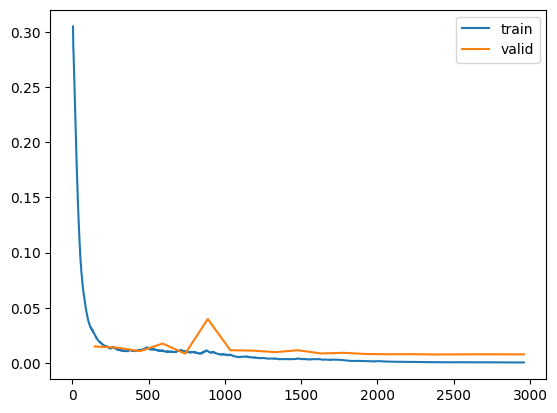

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000191           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0            0       30    0.06847   0.007733  0.069617  0.010347  12.71  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.132583
4.0    0.067628
5.0    0.057437
6.0    0.058181
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.181165
4.0    0.080244
5.0    0.038333
6.0    0.057581
Name: error, dtype: float64


[2023-08-06 19:07] start_frame: 0; seq_len: 40;


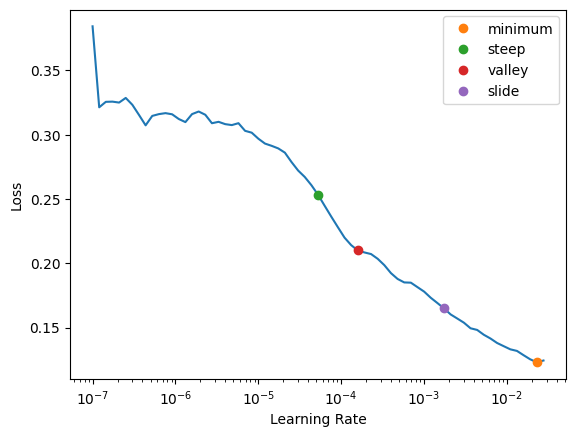

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028469,0.015299,0.090963,0.015299,00:47
1,0.014978,0.014814,0.087105,0.014814,00:46
2,0.014425,0.017261,0.101545,0.017261,00:46
3,0.013731,0.014267,0.088974,0.014267,00:46
4,0.013265,0.015060,0.086388,0.015060,00:47
5,0.011273,0.015086,0.085072,0.015086,00:46
6,0.008390,0.014073,0.084844,0.014073,00:46
7,0.005494,0.013223,0.084438,0.013223,00:46
8,0.004298,0.012625,0.084547,0.012625,00:46
9,0.004192,0.015065,0.096837,0.015065,00:47


Better model found at epoch 0 with mse value: 0.015299482271075249.
Better model found at epoch 1 with mse value: 0.014813542366027832.
Better model found at epoch 3 with mse value: 0.014267281629145145.
Better model found at epoch 6 with mse value: 0.014072580263018608.
Better model found at epoch 7 with mse value: 0.013223359361290932.
Better model found at epoch 8 with mse value: 0.012624834664165974.
Better model found at epoch 12 with mse value: 0.010887222364544868.


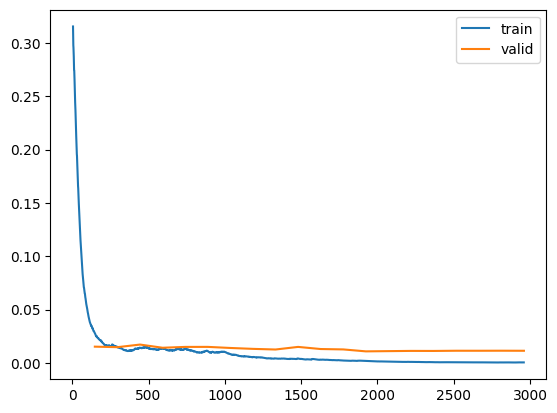

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0            0       40   0.078261   0.010887  0.080513  0.012322  16.43  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.170819
4.0    0.107248
5.0    0.053638
6.0    0.063515
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.208753
4.0    0.111756
5.0    0.053719
6.0    0.056834
Name: error, dtype: float64


[2023-08-06 19:24] start_frame: 0; seq_len: 50;


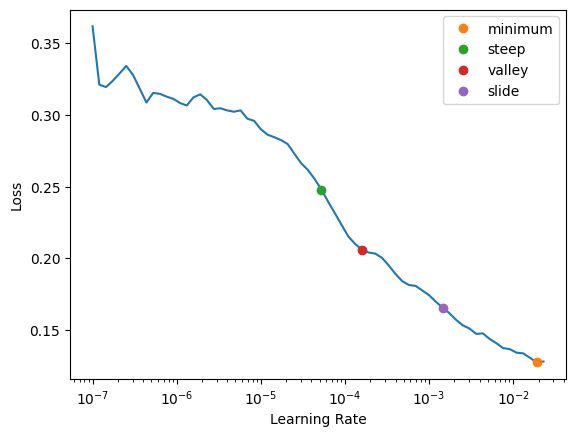

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028732,0.015389,0.092458,0.015389,00:56
1,0.014701,0.014609,0.089557,0.014609,00:56
2,0.014672,0.014914,0.093598,0.014914,00:56
3,0.013283,0.012941,0.086377,0.012941,00:56
4,0.012672,0.014956,0.090086,0.014956,00:56
5,0.010353,0.013333,0.084790,0.013333,00:56
6,0.008106,0.014669,0.088379,0.014669,00:56
7,0.005460,0.012479,0.092586,0.012479,00:57
8,0.004995,0.013663,0.090427,0.013663,00:57
9,0.003808,0.011942,0.087537,0.011942,00:57


Better model found at epoch 0 with mse value: 0.015389041975140572.
Better model found at epoch 1 with mse value: 0.014609347097575665.
Better model found at epoch 3 with mse value: 0.012940550222992897.
Better model found at epoch 7 with mse value: 0.012478929944336414.
Better model found at epoch 9 with mse value: 0.011942329816520214.


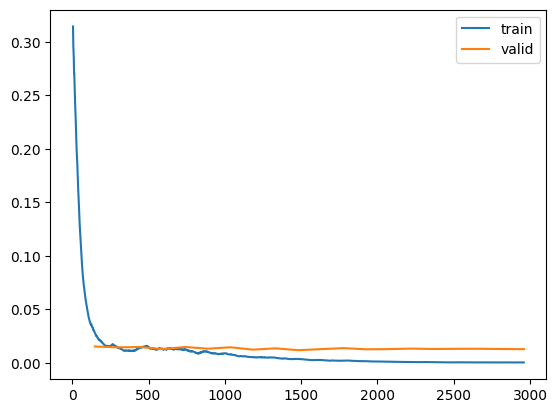

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0            0       50   0.087537   0.011942  0.087024   0.01424  20.02  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.172707
4.0    0.113792
5.0    0.056388
6.0    0.079791
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.220896
4.0    0.116414
5.0    0.042182
6.0    0.074335
Name: error, dtype: float64


[2023-08-06 19:44] start_frame: 5; seq_len: 20;


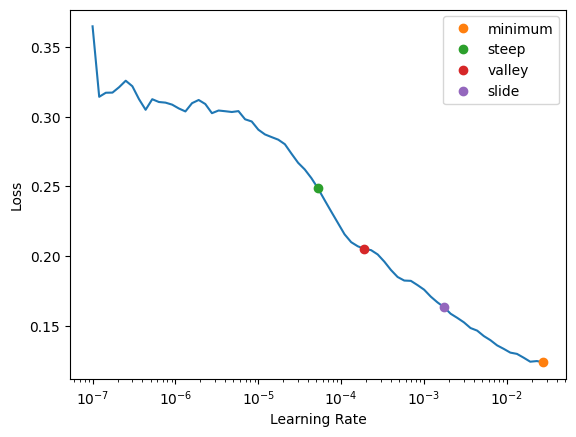

LR: 0.00019054606673307717


epoch,train_loss,valid_loss,mae,mse,time
0,0.024573,0.012225,0.084938,0.012225,00:26
1,0.010934,0.010901,0.078601,0.010901,00:26
2,0.012444,0.013485,0.087989,0.013485,00:26
3,0.011095,0.013233,0.089087,0.013233,00:26
4,0.010972,0.009515,0.069151,0.009515,00:26
5,0.010323,0.010066,0.071608,0.010066,00:26
6,0.008006,0.010269,0.075598,0.010269,00:26
7,0.005340,0.010763,0.075484,0.010763,00:26
8,0.005122,0.009581,0.071569,0.009581,00:25
9,0.004142,0.010918,0.077985,0.010918,00:26


Better model found at epoch 0 with mse value: 0.012224631384015083.
Better model found at epoch 1 with mse value: 0.010900541208684444.
Better model found at epoch 4 with mse value: 0.009515487588942051.
Better model found at epoch 11 with mse value: 0.008502180688083172.
Better model found at epoch 14 with mse value: 0.008117368444800377.
Better model found at epoch 15 with mse value: 0.007789937779307365.


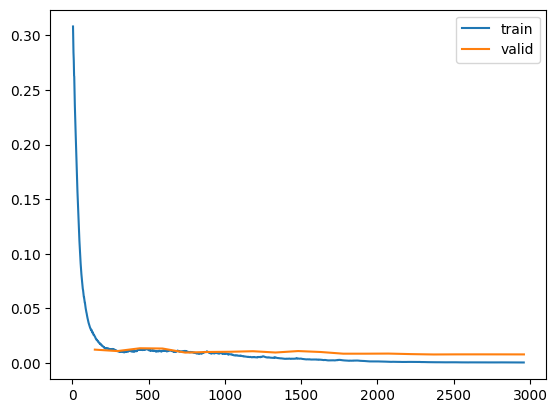

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000191           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0            5       20   0.065748    0.00779  0.068984   0.00953  9.26  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.106448
4.0    0.104140
5.0    0.047268
6.0    0.059538
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.166645
4.0    0.083451
5.0    0.043204
6.0    0.056370
Name: error, dtype: float64


[2023-08-06 19:53] start_frame: 5; seq_len: 30;


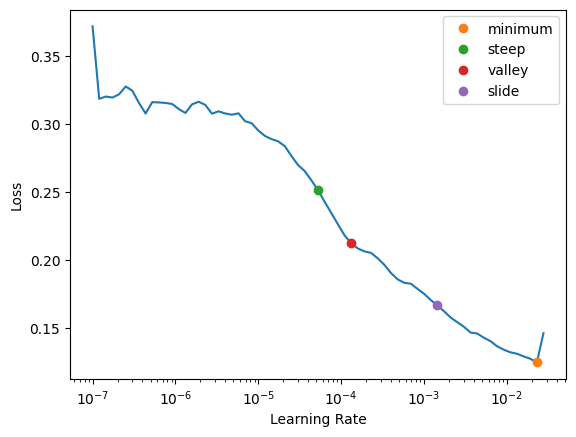

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031117,0.015829,0.095320,0.015829,00:36
1,0.014622,0.013786,0.094992,0.013786,00:36
2,0.013429,0.018396,0.105354,0.018396,00:36
3,0.012585,0.013062,0.087682,0.013062,00:36
4,0.010754,0.014731,0.085503,0.014731,00:35
5,0.009708,0.013939,0.090463,0.013939,00:36
6,0.007348,0.009321,0.074861,0.009321,00:36
7,0.005790,0.010908,0.084510,0.010908,00:36
8,0.005384,0.009988,0.077720,0.009988,00:36
9,0.004759,0.009515,0.079377,0.009515,00:36


Better model found at epoch 0 with mse value: 0.015828721225261688.
Better model found at epoch 1 with mse value: 0.013786302879452705.
Better model found at epoch 3 with mse value: 0.01306211482733488.
Better model found at epoch 6 with mse value: 0.00932059995830059.
Better model found at epoch 10 with mse value: 0.008369828574359417.
Better model found at epoch 11 with mse value: 0.007744047790765762.
Better model found at epoch 12 with mse value: 0.007501691114157438.


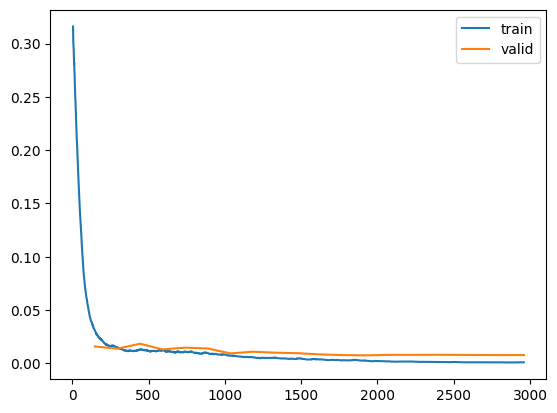

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0            5       30   0.068982   0.007502  0.064716  0.008713  12.83  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.127373
4.0    0.063102
5.0    0.037425
6.0    0.075138
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.165363
4.0    0.049057
5.0    0.031070
6.0    0.062348
Name: error, dtype: float64


[2023-08-06 20:06] start_frame: 5; seq_len: 40;


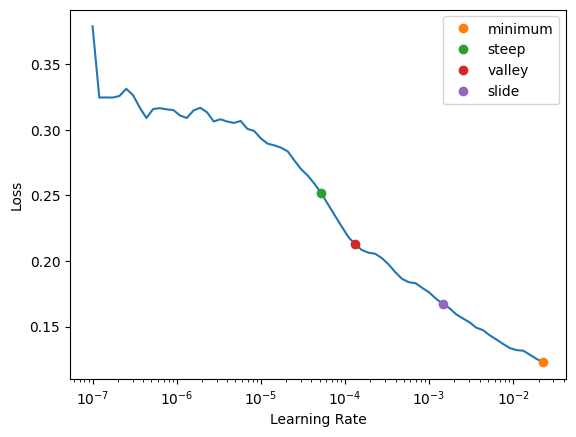

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031495,0.015074,0.093950,0.015074,00:46
1,0.016642,0.013611,0.090638,0.013611,00:47
2,0.014823,0.011728,0.080731,0.011728,00:46
3,0.013377,0.015168,0.100823,0.015168,00:46
4,0.014750,0.014395,0.097177,0.014395,00:46
5,0.014234,0.013270,0.085836,0.013270,00:46
6,0.011269,0.010118,0.077100,0.010118,00:47
7,0.007137,0.013492,0.097822,0.013492,00:46
8,0.006271,0.009267,0.067276,0.009267,00:46
9,0.005402,0.009009,0.072141,0.009009,00:46


Better model found at epoch 0 with mse value: 0.015074222348630428.
Better model found at epoch 1 with mse value: 0.013611271046102047.
Better model found at epoch 2 with mse value: 0.011728323996067047.
Better model found at epoch 6 with mse value: 0.010118475183844566.
Better model found at epoch 8 with mse value: 0.009267333894968033.
Better model found at epoch 9 with mse value: 0.009008717723190784.
Better model found at epoch 11 with mse value: 0.008741687051951885.
Better model found at epoch 12 with mse value: 0.008458543568849564.
Better model found at epoch 13 with mse value: 0.007718895561993122.
Better model found at epoch 14 with mse value: 0.007530611008405685.
Better model found at epoch 15 with mse value: 0.007485289126634598.
Better model found at epoch 17 with mse value: 0.007452860940247774.


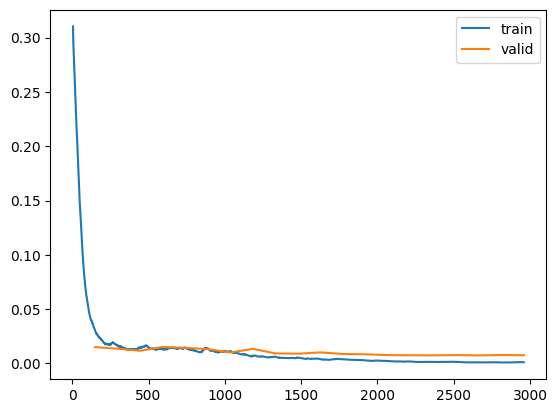

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0            5       40   0.067785   0.007453   0.07478  0.011122  16.54  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.115998
4.0    0.085088
5.0    0.055526
6.0    0.059299
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.205939
4.0    0.065496
5.0    0.052123
6.0    0.055234
Name: error, dtype: float64


[2023-08-06 20:23] start_frame: 5; seq_len: 50;


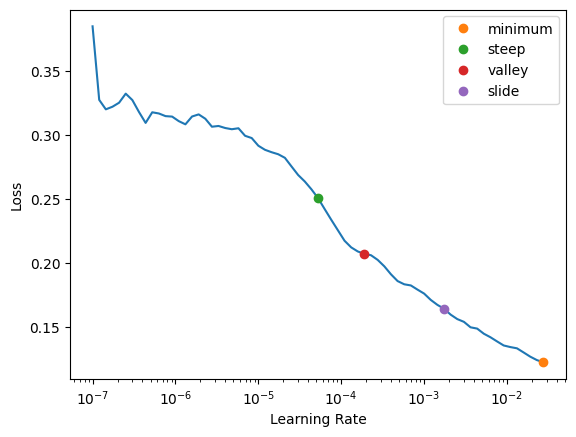

LR: 0.00019054606673307717


epoch,train_loss,valid_loss,mae,mse,time
0,0.026628,0.014146,0.089442,0.014146,00:56
1,0.014810,0.012505,0.077368,0.012505,00:57
2,0.015425,0.013645,0.086935,0.013645,00:57
3,0.015987,0.014474,0.087458,0.014474,00:57
4,0.015479,0.014145,0.089757,0.014145,00:56
5,0.014284,0.010480,0.074421,0.010480,00:56
6,0.012585,0.009138,0.071864,0.009138,00:57
7,0.009423,0.008981,0.071004,0.008981,00:57
8,0.008087,0.010341,0.073066,0.010341,00:58
9,0.007145,0.007884,0.070827,0.007884,00:58


Better model found at epoch 0 with mse value: 0.014145966619253159.
Better model found at epoch 1 with mse value: 0.012504606507718563.
Better model found at epoch 5 with mse value: 0.01047987025231123.
Better model found at epoch 6 with mse value: 0.009138202294707298.
Better model found at epoch 7 with mse value: 0.008980843238532543.
Better model found at epoch 9 with mse value: 0.007884175516664982.
Better model found at epoch 10 with mse value: 0.007814280688762665.
Better model found at epoch 12 with mse value: 0.007370204199105501.
Better model found at epoch 14 with mse value: 0.007142210844904184.
Better model found at epoch 16 with mse value: 0.0066992430947721004.
Better model found at epoch 17 with mse value: 0.006569011136889458.


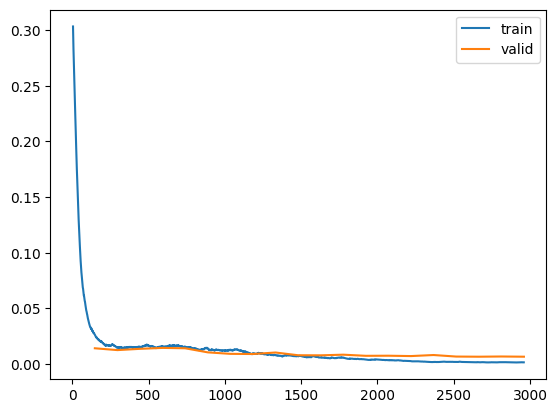

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000191           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0            5       50   0.061074   0.006569  0.068133  0.009377  20.27  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.125638
4.0    0.079041
5.0    0.041145
6.0    0.053081
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.161261
4.0    0.086261
5.0    0.047891
6.0    0.052339
Name: error, dtype: float64


[2023-08-06 20:43] start_frame: 10; seq_len: 20;


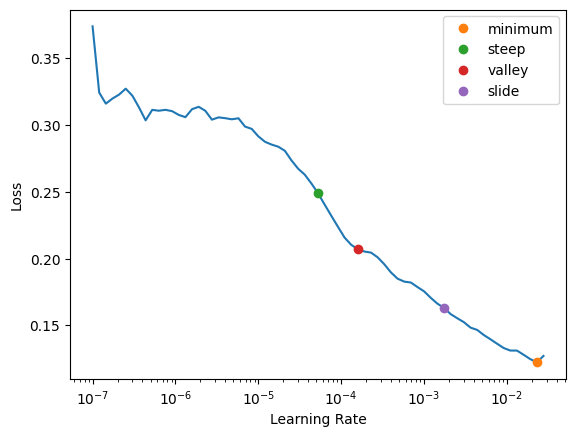

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.027321,0.014922,0.090409,0.014922,00:27
1,0.013308,0.012988,0.089613,0.012988,00:27
2,0.012608,0.015456,0.095478,0.015456,00:26
3,0.012132,0.010973,0.075824,0.010973,00:27
4,0.011210,0.014206,0.094434,0.014206,00:26
5,0.010495,0.008756,0.069997,0.008756,00:26
6,0.008133,0.014504,0.094572,0.014504,00:26
7,0.005529,0.009950,0.068581,0.009950,00:26
8,0.005704,0.007786,0.062122,0.007786,00:26
9,0.004668,0.007598,0.067484,0.007598,00:26


Better model found at epoch 0 with mse value: 0.014922482892870903.
Better model found at epoch 1 with mse value: 0.012987777590751648.
Better model found at epoch 3 with mse value: 0.010972567833960056.
Better model found at epoch 5 with mse value: 0.008756197057664394.
Better model found at epoch 8 with mse value: 0.007785833906382322.
Better model found at epoch 9 with mse value: 0.007597967516630888.
Better model found at epoch 10 with mse value: 0.007439699023962021.
Better model found at epoch 12 with mse value: 0.006676652934402227.
Better model found at epoch 13 with mse value: 0.006625684443861246.
Better model found at epoch 15 with mse value: 0.0066081383265554905.
Better model found at epoch 17 with mse value: 0.006602784618735313.


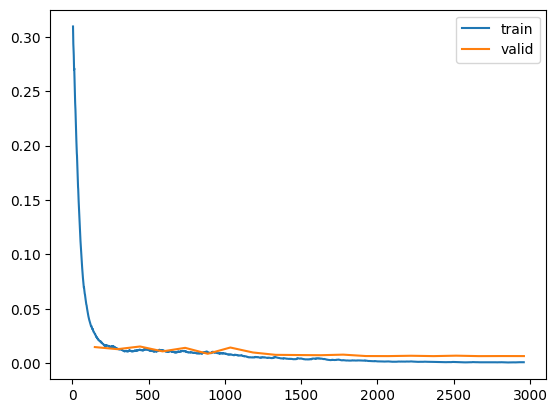

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           10       20   0.061234   0.006603  0.063974  0.008537   9.5  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.099240
4.0    0.086336
5.0    0.049521
6.0    0.053739
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.148270
4.0    0.085974
5.0    0.040329
6.0    0.052210
Name: error, dtype: float64


[2023-08-06 20:52] start_frame: 10; seq_len: 30;


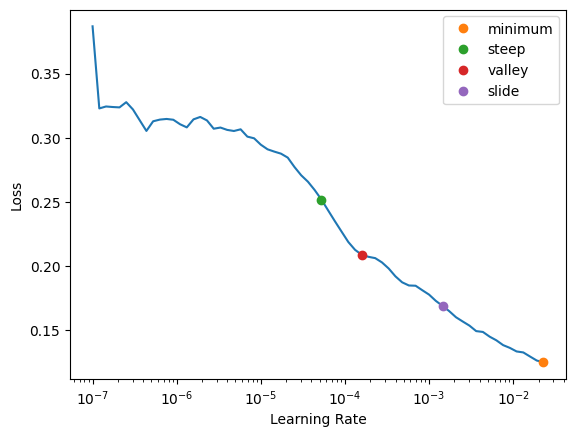

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028585,0.014792,0.092113,0.014792,00:36
1,0.015761,0.013638,0.090420,0.013638,00:36
2,0.014880,0.013947,0.094344,0.013947,00:36
3,0.014876,0.018389,0.095924,0.018389,00:37
4,0.014486,0.010572,0.079048,0.010572,00:37
5,0.014611,0.009247,0.073954,0.009247,00:37
6,0.011251,0.007165,0.063515,0.007165,00:37
7,0.007819,0.013825,0.095038,0.013825,00:36
8,0.007977,0.006636,0.060268,0.006636,00:37
9,0.006452,0.018669,0.114477,0.018669,00:36


Better model found at epoch 0 with mse value: 0.014792017638683319.
Better model found at epoch 1 with mse value: 0.013637800700962543.
Better model found at epoch 4 with mse value: 0.0105720991268754.
Better model found at epoch 5 with mse value: 0.00924671720713377.
Better model found at epoch 6 with mse value: 0.007164851296693087.
Better model found at epoch 8 with mse value: 0.006636443547904491.
Better model found at epoch 14 with mse value: 0.006470076739788055.
Better model found at epoch 15 with mse value: 0.006176086608320475.


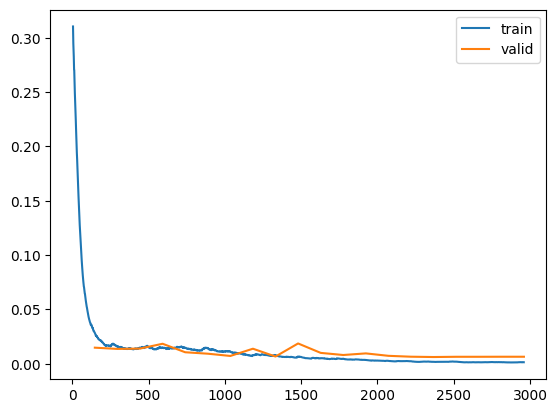

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           10       30   0.058686   0.006176   0.06028  0.007701  13.05  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.099539
4.0    0.082885
5.0    0.047235
6.0    0.050392
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.148343
4.0    0.074631
5.0    0.040532
6.0    0.046289
Name: error, dtype: float64


[2023-08-06 21:05] start_frame: 10; seq_len: 40;


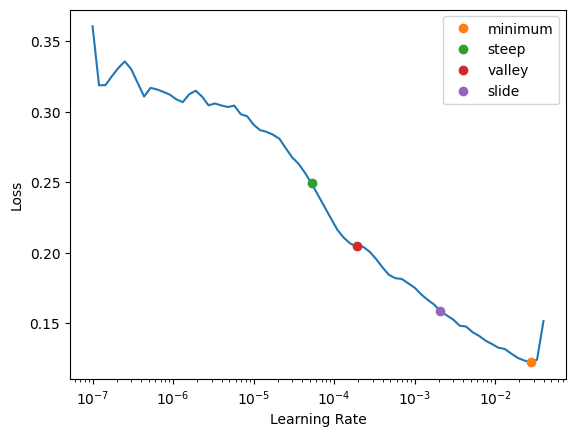

LR: 0.00019054606673307717


epoch,train_loss,valid_loss,mae,mse,time
0,0.026842,0.015273,0.096354,0.015273,00:47
1,0.015183,0.013835,0.086485,0.013835,00:48
2,0.015891,0.012206,0.090021,0.012206,00:48
3,0.013863,0.013614,0.086967,0.013614,00:47
4,0.017349,0.013155,0.087587,0.013155,00:47
5,0.014725,0.012095,0.085323,0.012095,00:48
6,0.011897,0.006013,0.058700,0.006013,00:47
7,0.009595,0.014954,0.104370,0.014954,00:47
8,0.008521,0.006144,0.059729,0.006144,00:47
9,0.008279,0.009804,0.081883,0.009804,00:47


Better model found at epoch 0 with mse value: 0.015273037366569042.
Better model found at epoch 1 with mse value: 0.013835377991199493.
Better model found at epoch 2 with mse value: 0.012206046842038631.
Better model found at epoch 5 with mse value: 0.012095044367015362.
Better model found at epoch 6 with mse value: 0.006012808997184038.


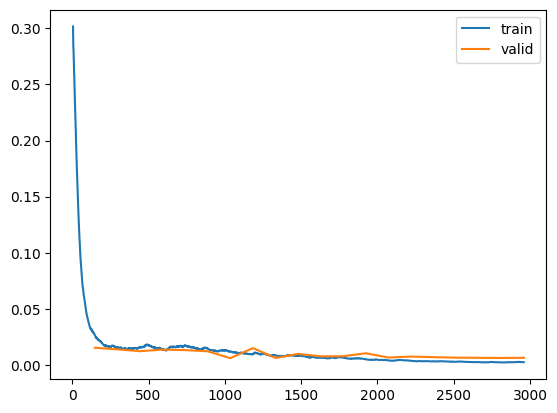

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000191           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           10       40     0.0587   0.006013  0.065886  0.008576  16.8  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.114180
4.0    0.080542
5.0    0.036922
6.0    0.053754
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.154965
4.0    0.073613
5.0    0.039593
6.0    0.057305
Name: error, dtype: float64


[2023-08-06 21:22] start_frame: 10; seq_len: 50;


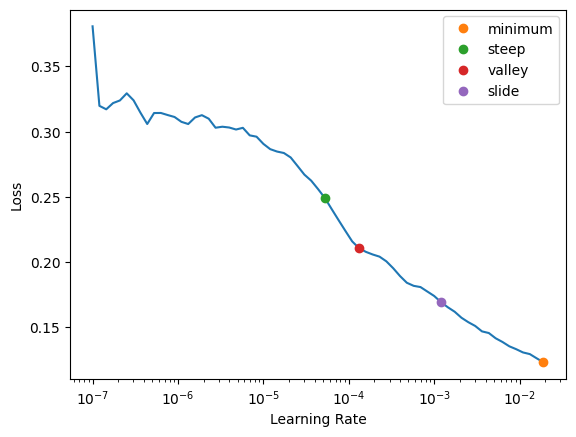

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031775,0.013949,0.089522,0.013949,00:57
1,0.015812,0.011879,0.081121,0.011879,00:57
2,0.014542,0.011291,0.085710,0.011291,00:57
3,0.014191,0.012213,0.079521,0.012213,00:57
4,0.014631,0.011531,0.076305,0.011531,00:57
5,0.015415,0.010228,0.076360,0.010228,00:58
6,0.011419,0.010450,0.075240,0.010450,00:57
7,0.009149,0.013153,0.092064,0.013153,00:57
8,0.007870,0.007156,0.062020,0.007156,00:58
9,0.006925,0.014040,0.099997,0.014040,00:58


Better model found at epoch 0 with mse value: 0.013949298299849033.
Better model found at epoch 1 with mse value: 0.011878575198352337.
Better model found at epoch 2 with mse value: 0.011291110888123512.
Better model found at epoch 5 with mse value: 0.010228349827229977.
Better model found at epoch 8 with mse value: 0.007156158797442913.
Better model found at epoch 11 with mse value: 0.005983132403343916.
Better model found at epoch 16 with mse value: 0.005963316187262535.
Better model found at epoch 17 with mse value: 0.005799679551273584.
Better model found at epoch 18 with mse value: 0.005742422770708799.
Better model found at epoch 19 with mse value: 0.005683268886059523.


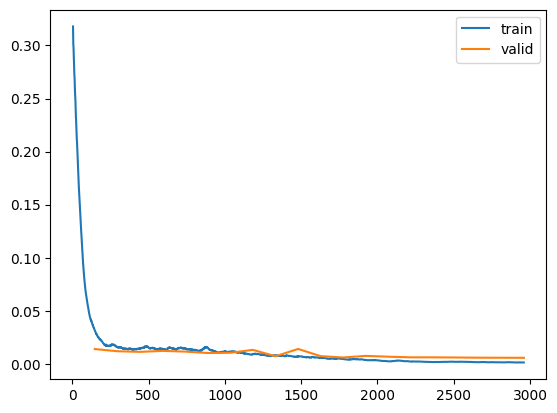

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           10       50   0.056229   0.005683  0.065312  0.007854  20.47  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.106246
4.0    0.084186
5.0    0.042658
6.0    0.046089
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.134804
4.0    0.077996
5.0    0.056613
6.0    0.049354
Name: error, dtype: float64


[2023-08-06 21:43] start_frame: 15; seq_len: 20;


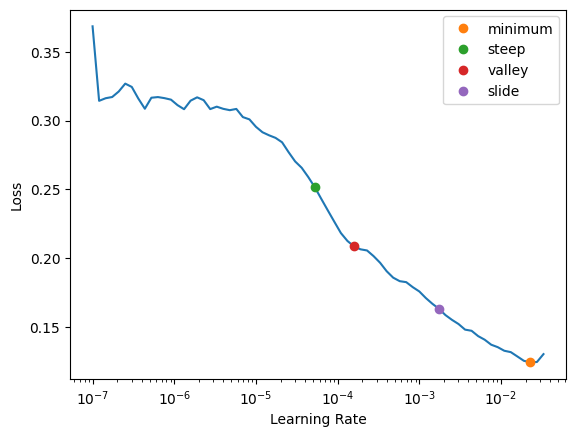

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028203,0.015773,0.094312,0.015773,00:27
1,0.014097,0.014836,0.095165,0.014836,00:27
2,0.014520,0.019585,0.109925,0.019585,00:27
3,0.012963,0.012536,0.079577,0.012536,00:27
4,0.011860,0.018218,0.110991,0.018218,00:27
5,0.012402,0.009577,0.080120,0.009577,00:27
6,0.009557,0.010540,0.074368,0.010540,00:27
7,0.006174,0.014451,0.095090,0.014451,00:27
8,0.005756,0.010086,0.076248,0.010086,00:27
9,0.005142,0.009113,0.075126,0.009113,00:27


Better model found at epoch 0 with mse value: 0.015773339197039604.
Better model found at epoch 1 with mse value: 0.014836259186267853.
Better model found at epoch 3 with mse value: 0.012536091729998589.
Better model found at epoch 5 with mse value: 0.009576791897416115.
Better model found at epoch 9 with mse value: 0.009113498963415623.
Better model found at epoch 10 with mse value: 0.008206416852772236.
Better model found at epoch 11 with mse value: 0.007833159528672695.
Better model found at epoch 12 with mse value: 0.006505709141492844.
Better model found at epoch 15 with mse value: 0.006231644190847874.
Better model found at epoch 18 with mse value: 0.0062225013971328735.
Better model found at epoch 19 with mse value: 0.006169785279780626.


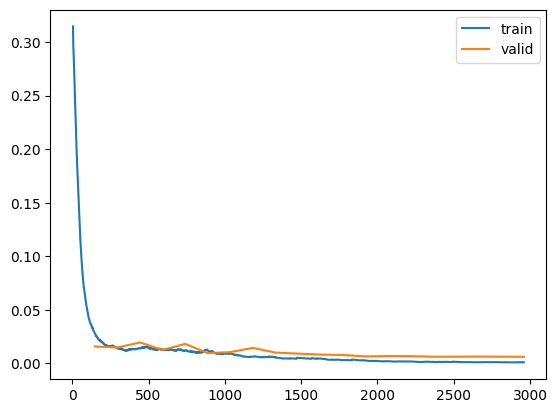

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           15       20   0.061981    0.00617  0.060235  0.007458  9.62  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.098574
4.0    0.072064
5.0    0.050936
6.0    0.057300
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.118973
4.0    0.078962
5.0    0.040111
6.0    0.053856
Name: error, dtype: float64


[2023-08-06 21:52] start_frame: 15; seq_len: 30;


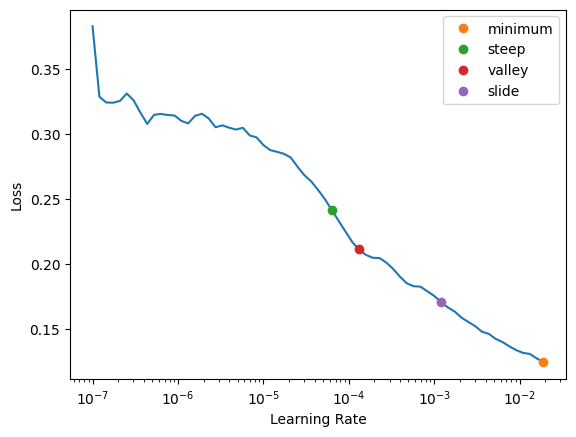

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031348,0.015044,0.092962,0.015044,00:37
1,0.016332,0.014238,0.096539,0.014238,00:37
2,0.015656,0.016416,0.105649,0.016416,00:37
3,0.013885,0.011567,0.085968,0.011567,00:37
4,0.014965,0.012628,0.089199,0.012628,00:37
5,0.014019,0.012219,0.085437,0.012219,00:37
6,0.011148,0.009718,0.070984,0.009718,00:37
7,0.009107,0.012106,0.091444,0.012106,00:37
8,0.007361,0.006843,0.065372,0.006843,00:37
9,0.006603,0.012557,0.094418,0.012557,00:36


Better model found at epoch 0 with mse value: 0.01504359021782875.
Better model found at epoch 1 with mse value: 0.014238320291042328.
Better model found at epoch 3 with mse value: 0.011566685512661934.
Better model found at epoch 6 with mse value: 0.009718367829918861.
Better model found at epoch 8 with mse value: 0.006842656061053276.
Better model found at epoch 11 with mse value: 0.006470652297139168.
Better model found at epoch 13 with mse value: 0.005832319613546133.
Better model found at epoch 14 with mse value: 0.005424748174846172.


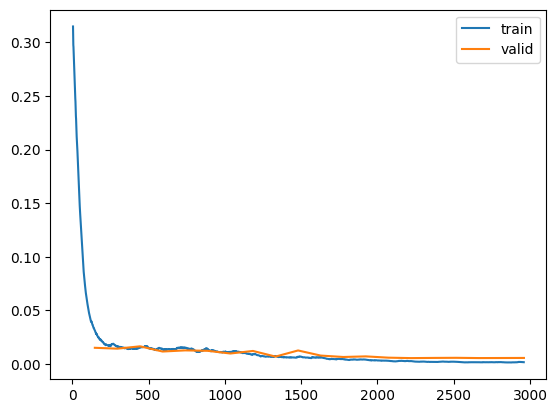

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           15       30   0.057727   0.005425   0.06177  0.007663  13.17  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.080435
4.0    0.092597
5.0    0.039838
6.0    0.056817
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.139763
4.0    0.083302
5.0    0.039363
6.0    0.051019
Name: error, dtype: float64


[2023-08-06 22:05] start_frame: 15; seq_len: 40;


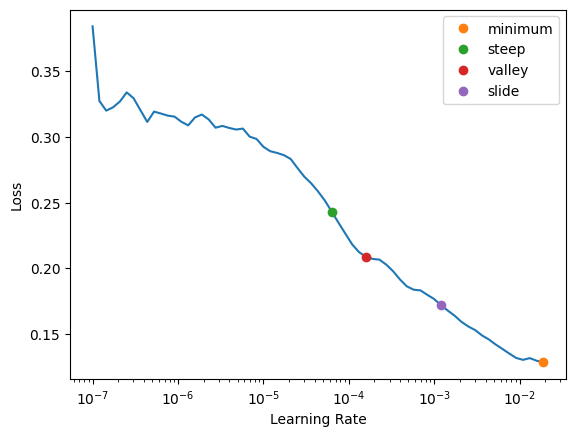

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028409,0.014660,0.086668,0.014660,00:48
1,0.016096,0.013743,0.085633,0.013743,00:48
2,0.016501,0.013413,0.085528,0.013413,00:48
3,0.014284,0.010960,0.081216,0.010960,00:47
4,0.016967,0.013787,0.095063,0.013787,00:47
5,0.014757,0.011250,0.082438,0.011250,00:48
6,0.012359,0.007335,0.063690,0.007335,00:47
7,0.009386,0.011979,0.087500,0.011979,00:47
8,0.008159,0.007396,0.065172,0.007396,00:47
9,0.007575,0.012056,0.090766,0.012056,00:47


Better model found at epoch 0 with mse value: 0.014659917913377285.
Better model found at epoch 1 with mse value: 0.013742721639573574.
Better model found at epoch 2 with mse value: 0.013412796892225742.
Better model found at epoch 3 with mse value: 0.010960083454847336.
Better model found at epoch 6 with mse value: 0.007334628142416477.
Better model found at epoch 10 with mse value: 0.005512770731002092.
Better model found at epoch 14 with mse value: 0.00482841394841671.
Better model found at epoch 18 with mse value: 0.004531146492809057.


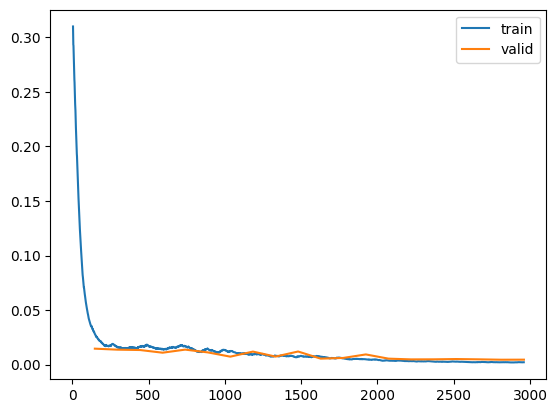

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           15       40   0.052073   0.004531  0.061731  0.007145  16.89  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.065790
4.0    0.081403
5.0    0.048740
6.0    0.044888
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.099893
4.0    0.093606
5.0    0.050704
6.0    0.052434
Name: error, dtype: float64


[2023-08-06 22:22] start_frame: 15; seq_len: 50;


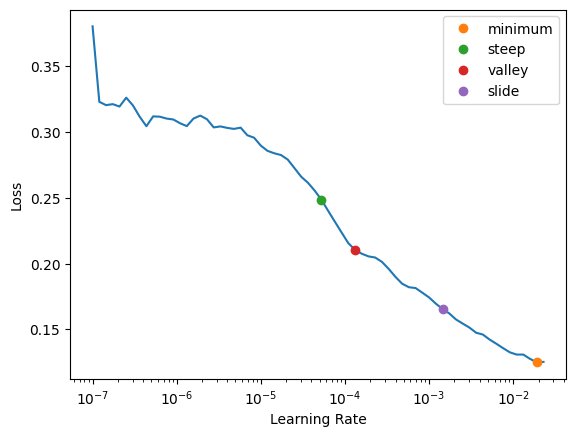

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031892,0.014525,0.092466,0.014525,00:58
1,0.016516,0.011386,0.084382,0.011386,00:58
2,0.014286,0.009981,0.076904,0.009981,00:58
3,0.014997,0.011573,0.081479,0.011573,00:58
4,0.014947,0.009465,0.074708,0.009465,00:58
5,0.014592,0.009762,0.080629,0.009762,00:58
6,0.012464,0.008480,0.066546,0.008480,00:58
7,0.009027,0.006783,0.064618,0.006783,00:58
8,0.009700,0.012434,0.088678,0.012434,00:59
9,0.008157,0.012373,0.093733,0.012373,00:58


Better model found at epoch 0 with mse value: 0.014524850063025951.
Better model found at epoch 1 with mse value: 0.011386271566152573.
Better model found at epoch 2 with mse value: 0.009980706498026848.
Better model found at epoch 4 with mse value: 0.009465152397751808.
Better model found at epoch 6 with mse value: 0.00847964733839035.
Better model found at epoch 7 with mse value: 0.0067825401201844215.
Better model found at epoch 12 with mse value: 0.005353652406483889.


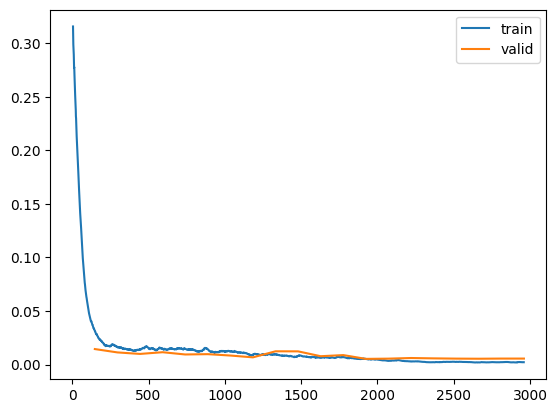

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           15       50   0.054954   0.005354  0.059626  0.007222  20.69  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.103636
4.0    0.080712
5.0    0.038972
6.0    0.047239
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.128145
4.0    0.075068
5.0    0.042685
6.0    0.048990
Name: error, dtype: float64


[2023-08-06 22:43] start_frame: 20; seq_len: 20;


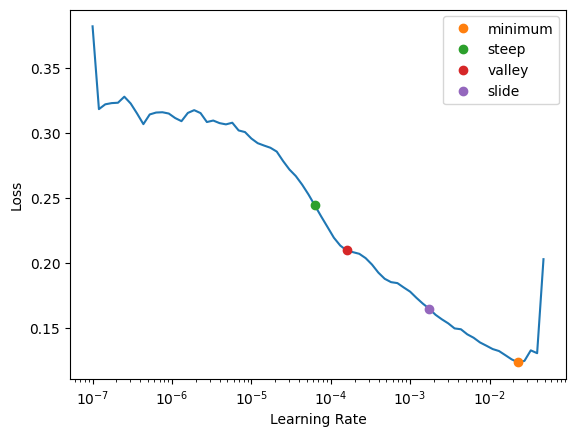

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028467,0.014925,0.093676,0.014925,00:27
1,0.015316,0.014321,0.088973,0.014321,00:27
2,0.015117,0.015917,0.093921,0.015917,00:27
3,0.014474,0.013371,0.085590,0.013371,00:27
4,0.016049,0.013670,0.092034,0.013670,00:27
5,0.014859,0.015845,0.101145,0.015845,00:27
6,0.011101,0.014788,0.091431,0.014788,00:27
7,0.007195,0.011742,0.083010,0.011742,00:27
8,0.007818,0.009166,0.070201,0.009166,00:27
9,0.006787,0.011510,0.089618,0.011510,00:27


Better model found at epoch 0 with mse value: 0.014925285242497921.
Better model found at epoch 1 with mse value: 0.014320672489702702.
Better model found at epoch 3 with mse value: 0.01337070856243372.
Better model found at epoch 7 with mse value: 0.011742208153009415.
Better model found at epoch 8 with mse value: 0.009165842086076736.
Better model found at epoch 10 with mse value: 0.009004294872283936.
Better model found at epoch 11 with mse value: 0.007773259654641151.
Better model found at epoch 14 with mse value: 0.007281394675374031.


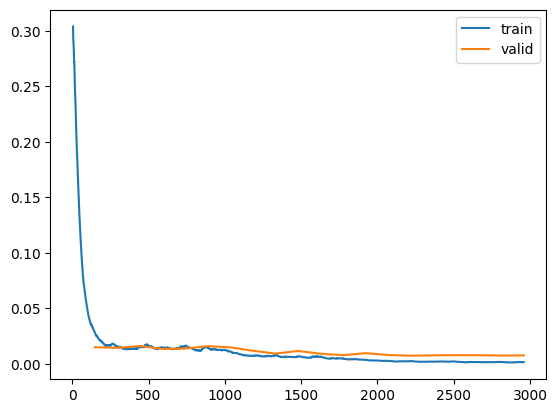

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           20       20   0.065821   0.007281  0.070998  0.010497  9.76  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.112594
4.0    0.083394
5.0    0.053129
6.0    0.057978
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.183182
4.0    0.055865
5.0    0.041574
6.0    0.062450
Name: error, dtype: float64


[2023-08-06 22:53] start_frame: 20; seq_len: 30;


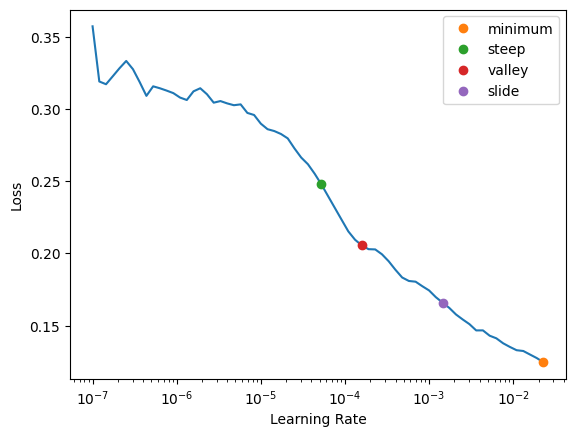

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028808,0.015195,0.091605,0.015195,00:37
1,0.016518,0.014123,0.085827,0.014123,00:37
2,0.015331,0.010846,0.078877,0.010846,00:37
3,0.014969,0.011084,0.079946,0.011084,00:38
4,0.015784,0.012126,0.079840,0.012126,00:37
5,0.015732,0.008123,0.064952,0.008123,00:37
6,0.012052,0.008509,0.066578,0.008509,00:37
7,0.008950,0.025560,0.133558,0.025560,00:37
8,0.008047,0.007635,0.069451,0.007635,00:37
9,0.007606,0.011275,0.082280,0.011275,00:37


Better model found at epoch 0 with mse value: 0.01519504189491272.
Better model found at epoch 1 with mse value: 0.014123047702014446.
Better model found at epoch 2 with mse value: 0.010845591314136982.
Better model found at epoch 5 with mse value: 0.008122516795992851.
Better model found at epoch 8 with mse value: 0.007635466754436493.
Better model found at epoch 10 with mse value: 0.006661536172032356.
Better model found at epoch 15 with mse value: 0.005760209169238806.


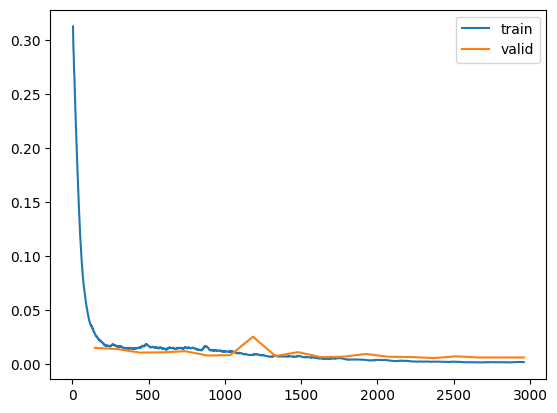

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           20       30   0.055145    0.00576  0.062424  0.007887  13.27  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.080378
4.0    0.112470
5.0    0.046252
6.0    0.043151
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.140881
4.0    0.085485
5.0    0.046360
6.0    0.046960
Name: error, dtype: float64


[2023-08-06 23:06] start_frame: 20; seq_len: 40;


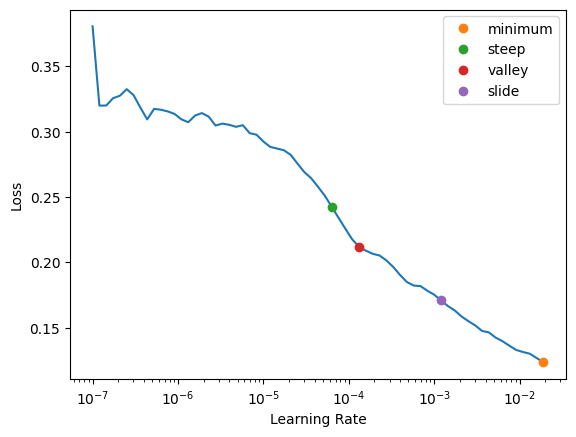

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031520,0.014465,0.087347,0.014465,00:47
1,0.016530,0.013083,0.091414,0.013083,00:48
2,0.015964,0.013851,0.097016,0.013851,00:48
3,0.013705,0.009349,0.078082,0.009349,00:47
4,0.015174,0.014389,0.096147,0.014389,00:47
5,0.015127,0.012170,0.078842,0.012170,00:49
6,0.011384,0.007117,0.062116,0.007117,00:48
7,0.008751,0.010112,0.081407,0.010112,00:47
8,0.007934,0.006342,0.057923,0.006342,00:48
9,0.006785,0.009285,0.074478,0.009285,00:47


Better model found at epoch 0 with mse value: 0.014464948326349258.
Better model found at epoch 1 with mse value: 0.013083050958812237.
Better model found at epoch 3 with mse value: 0.009348783642053604.
Better model found at epoch 6 with mse value: 0.0071165733970701694.
Better model found at epoch 8 with mse value: 0.006341954227536917.
Better model found at epoch 10 with mse value: 0.0059299287386238575.
Better model found at epoch 14 with mse value: 0.0054900129325687885.
Better model found at epoch 15 with mse value: 0.004324549809098244.


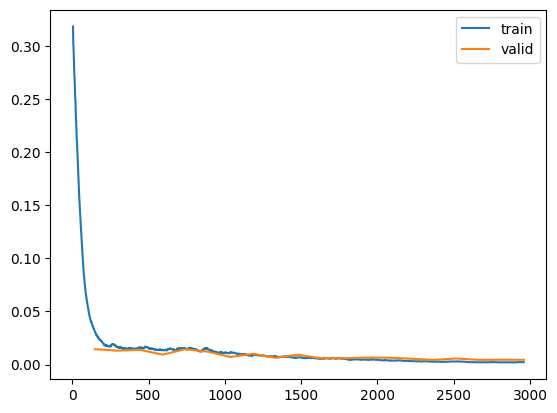

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           20       40   0.048862   0.004325  0.053154  0.006147  16.92  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.067587
4.0    0.080626
5.0    0.052837
6.0    0.034869
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.103730
4.0    0.073714
5.0    0.045434
6.0    0.040314
Name: error, dtype: float64


[2023-08-06 23:23] start_frame: 20; seq_len: 50;


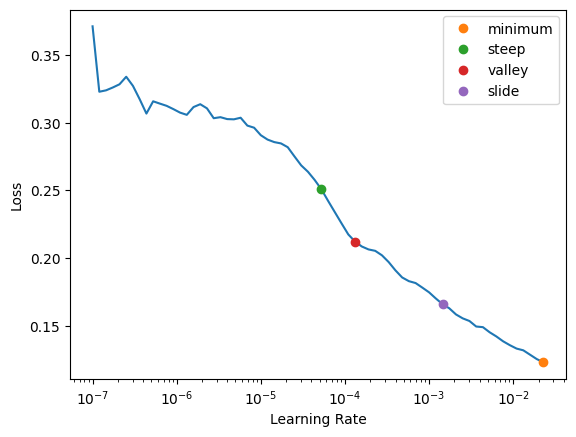

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.032044,0.013782,0.090736,0.013782,00:58
1,0.016986,0.012457,0.087360,0.012457,00:58
2,0.015400,0.012840,0.088587,0.012840,00:58
3,0.015505,0.011710,0.079345,0.011710,00:58
4,0.015731,0.011098,0.075722,0.011098,00:59
5,0.015868,0.008483,0.066396,0.008483,00:58
6,0.011648,0.009796,0.069946,0.009796,00:58
7,0.010159,0.021870,0.125132,0.021870,00:58
8,0.008978,0.007546,0.068811,0.007546,00:59
9,0.007387,0.012580,0.090919,0.012580,00:59


Better model found at epoch 0 with mse value: 0.013782438822090626.
Better model found at epoch 1 with mse value: 0.012456555850803852.
Better model found at epoch 3 with mse value: 0.011710328049957752.
Better model found at epoch 4 with mse value: 0.01109774224460125.
Better model found at epoch 5 with mse value: 0.008483311161398888.
Better model found at epoch 8 with mse value: 0.007546279579401016.
Better model found at epoch 11 with mse value: 0.006253561936318874.
Better model found at epoch 12 with mse value: 0.005418484099209309.
Better model found at epoch 14 with mse value: 0.0053948694840073586.
Better model found at epoch 15 with mse value: 0.005341720301657915.
Better model found at epoch 17 with mse value: 0.005080557893961668.


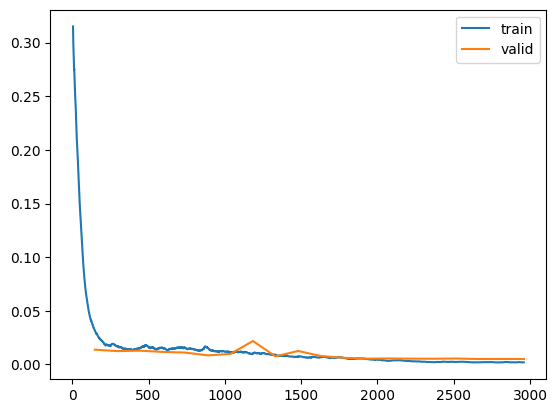

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           20       50   0.053987   0.005081   0.06189  0.007407  20.7  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.079932
4.0    0.092598
5.0    0.048272
6.0    0.043222
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.122046
4.0    0.076629
5.0    0.053686
6.0    0.047815
Name: error, dtype: float64


[2023-08-06 23:44] start_frame: 25; seq_len: 20;


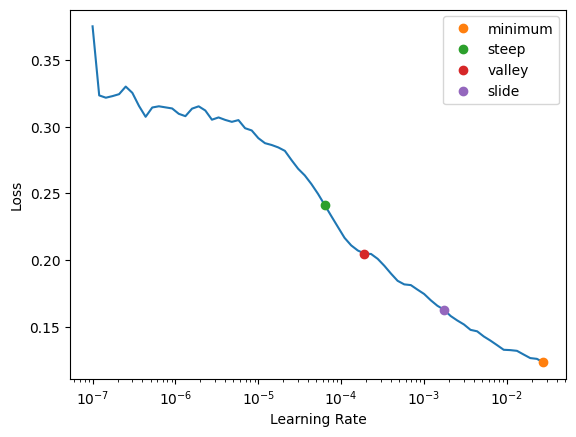

LR: 0.00019054606673307717


epoch,train_loss,valid_loss,mae,mse,time
0,0.025997,0.013868,0.092197,0.013868,00:27
1,0.014973,0.011933,0.084702,0.011933,00:27
2,0.015414,0.015331,0.096216,0.015331,00:27
3,0.015726,0.015499,0.096597,0.015499,00:27
4,0.016256,0.013889,0.087737,0.013889,00:27
5,0.016131,0.021815,0.124883,0.021815,00:26
6,0.012245,0.010167,0.076338,0.010167,00:27
7,0.011005,0.014935,0.097742,0.014935,00:27
8,0.009101,0.010429,0.081878,0.010429,00:27
9,0.007925,0.012032,0.081950,0.012032,00:27


Better model found at epoch 0 with mse value: 0.013868472538888454.
Better model found at epoch 1 with mse value: 0.011933115310966969.
Better model found at epoch 6 with mse value: 0.010167010128498077.
Better model found at epoch 10 with mse value: 0.009688149206340313.
Better model found at epoch 12 with mse value: 0.009040670469403267.
Better model found at epoch 14 with mse value: 0.008620921522378922.
Better model found at epoch 15 with mse value: 0.007960057817399502.


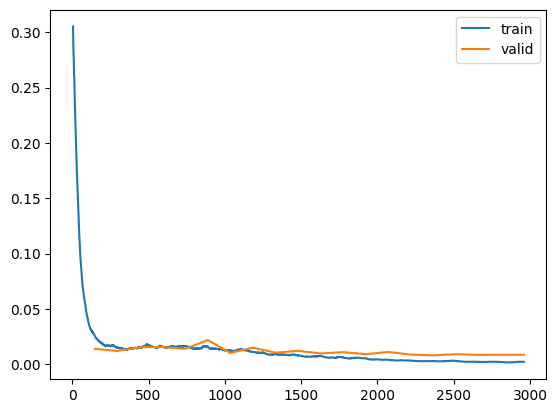

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000191           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           25       20   0.066054    0.00796  0.071797  0.009941  9.66  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.106781
4.0    0.078991
5.0    0.045093
6.0    0.066380
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.161578
4.0    0.083783
5.0    0.049143
6.0    0.059745
Name: error, dtype: float64


[2023-08-06 23:53] start_frame: 25; seq_len: 30;


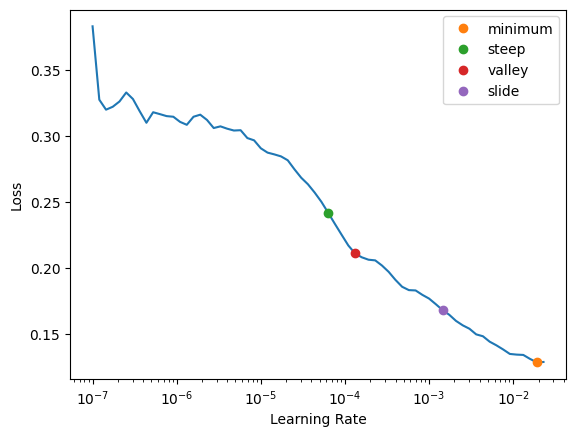

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031574,0.014546,0.091329,0.014546,00:38
1,0.016437,0.012972,0.087307,0.012972,00:36
2,0.016924,0.012060,0.090513,0.012060,00:37
3,0.014297,0.010985,0.084476,0.010985,00:37
4,0.015799,0.010444,0.079727,0.010444,00:36
5,0.014584,0.009909,0.073420,0.009909,00:36
6,0.011766,0.007586,0.068613,0.007586,00:36
7,0.009482,0.007665,0.065512,0.007665,00:36
8,0.008689,0.008032,0.071030,0.008032,00:35
9,0.007384,0.015381,0.098912,0.015381,00:36


Better model found at epoch 0 with mse value: 0.014546064659953117.
Better model found at epoch 1 with mse value: 0.012972330674529076.
Better model found at epoch 2 with mse value: 0.012060035951435566.
Better model found at epoch 3 with mse value: 0.010984634049236774.
Better model found at epoch 4 with mse value: 0.010443707928061485.
Better model found at epoch 5 with mse value: 0.009908786043524742.
Better model found at epoch 6 with mse value: 0.007585686165839434.
Better model found at epoch 12 with mse value: 0.006567420903593302.
Better model found at epoch 14 with mse value: 0.004715528339147568.


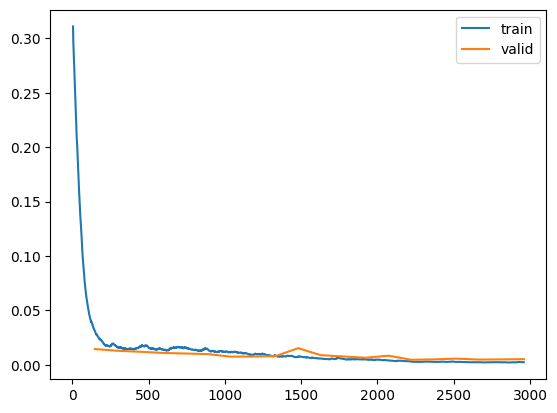

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           25       30   0.055068   0.004716  0.062344  0.008186  12.85  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.070144
4.0    0.095468
5.0    0.046797
6.0    0.048728
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.109336
4.0    0.083882
5.0    0.050922
6.0    0.052823
Name: error, dtype: float64


[2023-08-07 00:06] start_frame: 25; seq_len: 40;


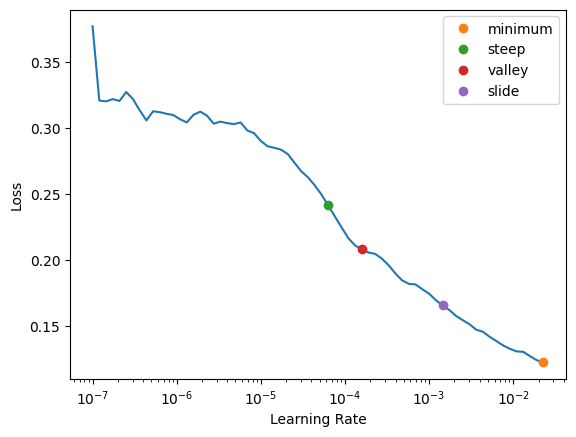

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028743,0.014714,0.088217,0.014714,00:46
1,0.016363,0.013163,0.083156,0.013163,00:47
2,0.014643,0.013390,0.085000,0.013390,00:45
3,0.015794,0.012130,0.084845,0.012130,00:47
4,0.015739,0.010411,0.080617,0.010411,00:46
5,0.015875,0.007120,0.061575,0.007120,00:47
6,0.013061,0.010900,0.072679,0.010900,00:46
7,0.008890,0.009632,0.078897,0.009632,00:46
8,0.009268,0.007218,0.065103,0.007218,00:46
9,0.007740,0.007974,0.068421,0.007974,00:47


Better model found at epoch 0 with mse value: 0.014713894575834274.
Better model found at epoch 1 with mse value: 0.013163410127162933.
Better model found at epoch 3 with mse value: 0.01212979108095169.
Better model found at epoch 4 with mse value: 0.010411332361400127.
Better model found at epoch 5 with mse value: 0.007120307069271803.
Better model found at epoch 10 with mse value: 0.006613343022763729.
Better model found at epoch 11 with mse value: 0.006176052149385214.
Better model found at epoch 17 with mse value: 0.005956747569143772.
Better model found at epoch 18 with mse value: 0.005609269719570875.


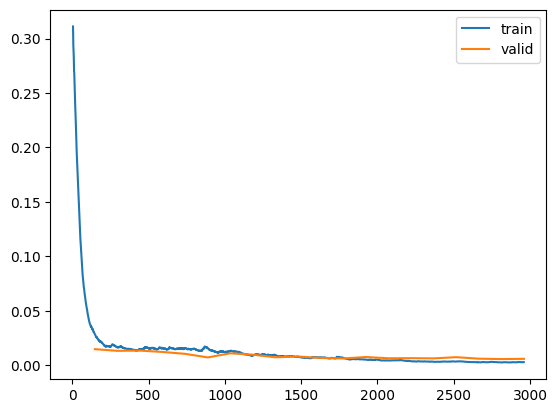

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           25       40   0.057431   0.005609  0.059426  0.007413  16.51  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.068556
4.0    0.105879
5.0    0.051293
6.0    0.049213
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.108722
4.0    0.072207
5.0    0.050576
6.0    0.049195
Name: error, dtype: float64


[2023-08-07 00:23] start_frame: 25; seq_len: 50;


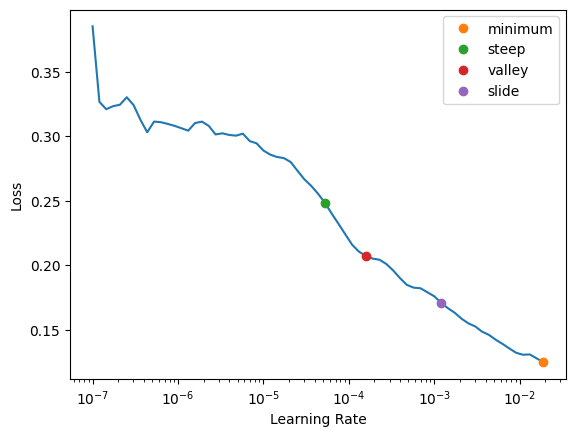

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.028904,0.013771,0.086526,0.013771,00:58
1,0.015740,0.011867,0.078724,0.011867,00:57
2,0.016041,0.012222,0.085688,0.012222,00:57
3,0.015018,0.012290,0.083665,0.012290,00:57
4,0.016071,0.011073,0.080002,0.011073,00:57
5,0.015718,0.016971,0.108074,0.016971,00:57
6,0.012422,0.011259,0.075560,0.011259,00:56
7,0.009025,0.008310,0.071769,0.008310,00:56
8,0.009114,0.007837,0.067623,0.007837,00:56
9,0.007376,0.006893,0.064504,0.006893,00:56


Better model found at epoch 0 with mse value: 0.013771215453743935.
Better model found at epoch 1 with mse value: 0.011866950429975986.
Better model found at epoch 4 with mse value: 0.01107325404882431.
Better model found at epoch 7 with mse value: 0.008310437202453613.
Better model found at epoch 8 with mse value: 0.007837064564228058.
Better model found at epoch 9 with mse value: 0.006892945617437363.
Better model found at epoch 11 with mse value: 0.005725230555981398.
Better model found at epoch 14 with mse value: 0.005533609073609114.
Better model found at epoch 15 with mse value: 0.005236875731498003.
Better model found at epoch 17 with mse value: 0.005118352826684713.
Better model found at epoch 18 with mse value: 0.0051163057796657085.


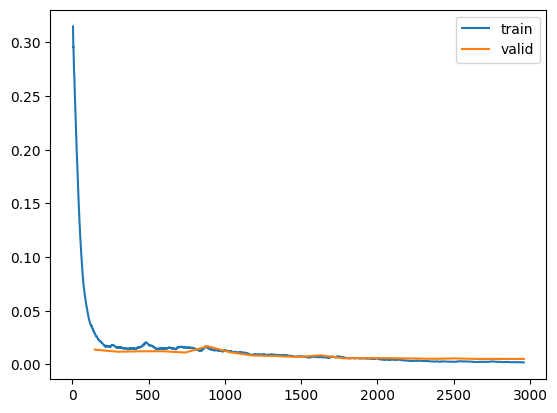

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           25       50   0.051953   0.005116   0.05689  0.006074  19.99  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.067301
4.0    0.090008
5.0    0.048263
6.0    0.042885
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.089827
4.0    0.065849
5.0    0.044908
6.0    0.054079
Name: error, dtype: float64


[2023-08-07 00:43] start_frame: 30; seq_len: 20;


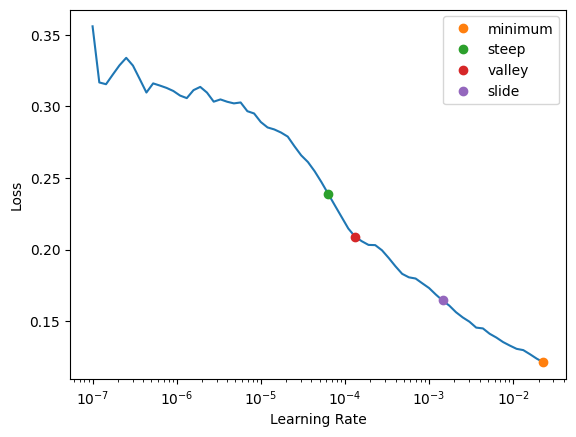

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031355,0.015439,0.097942,0.015439,00:26
1,0.017110,0.015521,0.102997,0.015521,00:25
2,0.015779,0.015815,0.100045,0.015815,00:26
3,0.014008,0.012488,0.085531,0.012488,00:25
4,0.015575,0.012276,0.092653,0.012276,00:25
5,0.015676,0.012804,0.092611,0.012804,00:25
6,0.012731,0.014784,0.083863,0.014784,00:25
7,0.010196,0.015389,0.096314,0.015389,00:25
8,0.009858,0.008675,0.068260,0.008675,00:25
9,0.008417,0.014555,0.096963,0.014555,00:25


Better model found at epoch 0 with mse value: 0.015439226292073727.
Better model found at epoch 3 with mse value: 0.01248756144195795.
Better model found at epoch 4 with mse value: 0.012275850400328636.
Better model found at epoch 8 with mse value: 0.00867457129061222.
Better model found at epoch 14 with mse value: 0.007812403608113527.


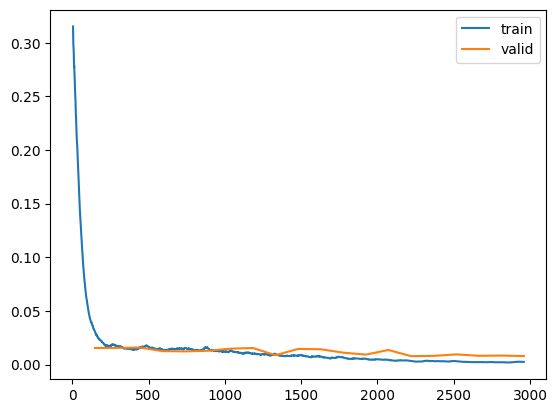

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           30       20   0.066512   0.007812  0.070975  0.010237   9.0  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.091823
4.0    0.101993
5.0    0.060474
6.0    0.056742
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.142595
4.0    0.092013
5.0    0.068110
6.0    0.048880
Name: error, dtype: float64


[2023-08-07 00:52] start_frame: 30; seq_len: 30;


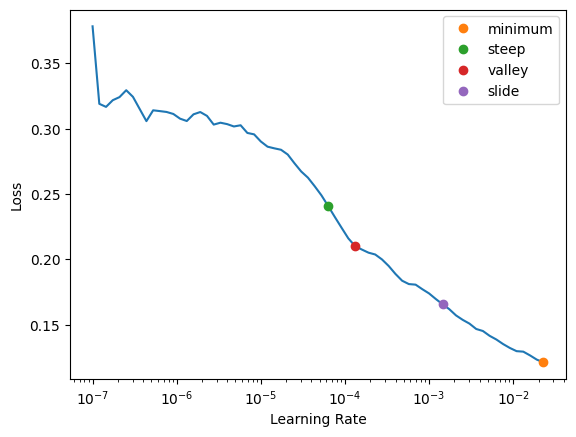

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031796,0.014361,0.090009,0.014361,00:35
1,0.016666,0.011763,0.087075,0.011763,00:34
2,0.016019,0.008727,0.072983,0.008727,00:34
3,0.014198,0.008628,0.069774,0.008628,00:34
4,0.015212,0.010564,0.069666,0.010564,00:35
5,0.014796,0.008426,0.068087,0.008426,00:34
6,0.012356,0.007712,0.063095,0.007712,00:35
7,0.009399,0.010622,0.083118,0.010622,00:34
8,0.009653,0.012241,0.093417,0.012241,00:34
9,0.008211,0.016678,0.101330,0.016678,00:35


Better model found at epoch 0 with mse value: 0.014361013658344746.
Better model found at epoch 1 with mse value: 0.011763449758291245.
Better model found at epoch 2 with mse value: 0.008726600557565689.
Better model found at epoch 3 with mse value: 0.008627544157207012.
Better model found at epoch 5 with mse value: 0.008426014333963394.
Better model found at epoch 6 with mse value: 0.007712150923907757.
Better model found at epoch 11 with mse value: 0.006735850591212511.
Better model found at epoch 15 with mse value: 0.006212522741407156.
Better model found at epoch 17 with mse value: 0.006130308844149113.


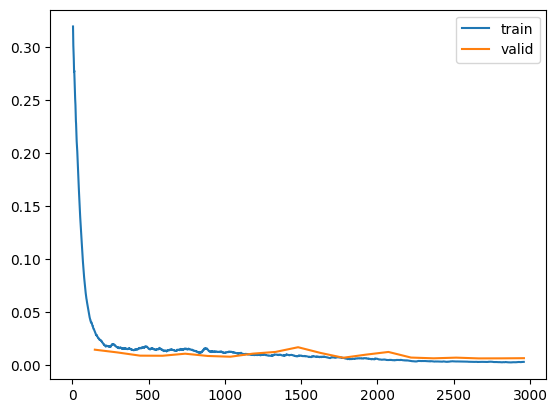

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           30       30   0.059164    0.00613  0.067582   0.00869  12.29  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.078932
4.0    0.093353
5.0    0.054095
6.0    0.050533
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.108080
4.0    0.074449
5.0    0.069704
6.0    0.053519
Name: error, dtype: float64


[2023-08-07 01:04] start_frame: 30; seq_len: 40;


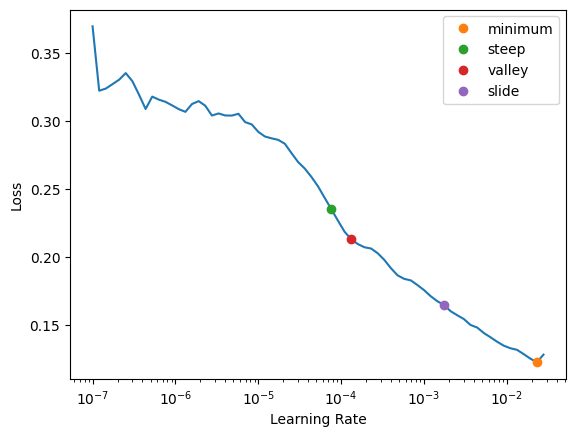

LR: 0.00013182566908653826


epoch,train_loss,valid_loss,mae,mse,time
0,0.031907,0.014227,0.089632,0.014227,00:44
1,0.016448,0.012137,0.084811,0.012137,00:44
2,0.016418,0.012265,0.089441,0.012265,00:44
3,0.015106,0.012158,0.081244,0.012158,00:44
4,0.014717,0.012321,0.080104,0.012321,00:45
5,0.014232,0.010733,0.081521,0.010733,00:44
6,0.011557,0.007219,0.063385,0.007219,00:44
7,0.008714,0.010862,0.084275,0.010862,00:44
8,0.008139,0.004614,0.052072,0.004614,00:44
9,0.006573,0.009149,0.070814,0.009149,00:45


Better model found at epoch 0 with mse value: 0.014227274805307388.
Better model found at epoch 1 with mse value: 0.012137392535805702.
Better model found at epoch 5 with mse value: 0.01073263119906187.
Better model found at epoch 6 with mse value: 0.007218932267278433.
Better model found at epoch 8 with mse value: 0.004614419769495726.


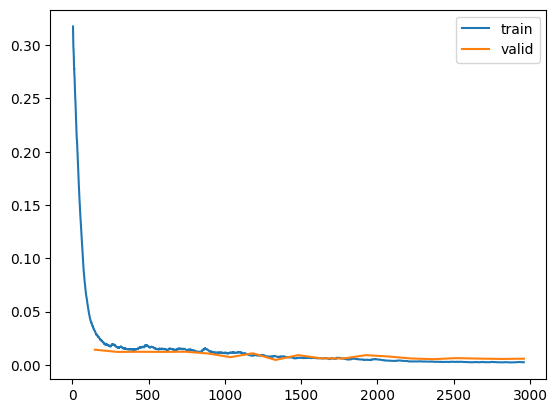

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000132           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse  time  
0           30       40   0.052072   0.004614  0.066371  0.009421  15.7  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.063939
4.0    0.100479
5.0    0.036127
6.0    0.050289
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.144305
4.0    0.089848
5.0    0.050310
6.0    0.050971
Name: error, dtype: float64


[2023-08-07 01:20] start_frame: 30; seq_len: 50;


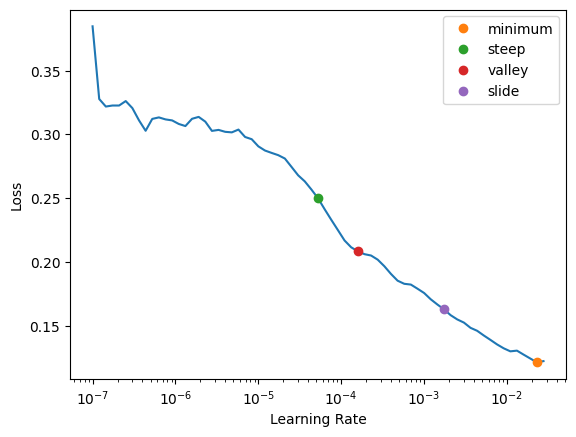

LR: 0.00015848931798245758


epoch,train_loss,valid_loss,mae,mse,time
0,0.029092,0.015168,0.091867,0.015168,00:54
1,0.016148,0.012922,0.085030,0.012922,00:54
2,0.016130,0.011463,0.082406,0.011463,00:54
3,0.015364,0.011307,0.083302,0.011307,00:54
4,0.015951,0.014021,0.085183,0.014021,00:55
5,0.014913,0.012240,0.092005,0.012240,00:55
6,0.012727,0.011492,0.082543,0.011492,00:54
7,0.010078,0.017147,0.102443,0.017147,00:54
8,0.008710,0.011297,0.086659,0.011297,00:54
9,0.006929,0.007301,0.064729,0.007301,00:54


Better model found at epoch 0 with mse value: 0.015168001875281334.
Better model found at epoch 1 with mse value: 0.012922455556690693.
Better model found at epoch 2 with mse value: 0.011462897062301636.
Better model found at epoch 3 with mse value: 0.011306997388601303.
Better model found at epoch 8 with mse value: 0.011296750046312809.
Better model found at epoch 9 with mse value: 0.0073008546605706215.
Better model found at epoch 10 with mse value: 0.006635303143411875.
Better model found at epoch 12 with mse value: 0.006349131464958191.
Better model found at epoch 13 with mse value: 0.005754302255809307.
Better model found at epoch 14 with mse value: 0.005001576151698828.


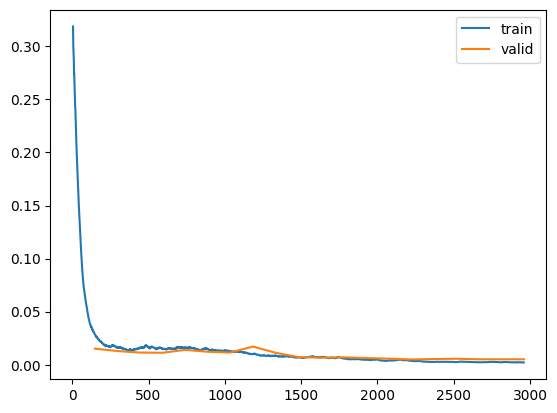

  model_arch   bcet  oversmp  batch_aug  epochs        lr  batch_size  \
0   resnet34  False        0      False      20  0.000158           8   

   start_frame  seq_len  valid_mae  valid_mse  test_mae  test_mse   time  
0           30       50   0.054444   0.005002  0.063997  0.008131  19.22  

Valid - MAE por banda de FEVI
FEVI10
3.0    0.083033
4.0    0.084655
5.0    0.042874
6.0    0.048508
Name: error, dtype: float32

Test MAE por banda de FEVI
FEVI10
3.0    0.109684
4.0    0.085354
5.0    0.052068
6.0    0.055219
Name: error, dtype: float64
Total time: 6.89


In [ ]:
file_path = f"/content/gdrive/MyDrive/TFM/pruebas/"
file_name = f"{file_path}/regression-resnet34-lstm-diff_frames-lag_100ms-grid_search-{datetime.now().strftime('%Y-%m-%d %H:%M')}.csv"


t0 = time.time()

# Definimos transformaciones para batch augmentation
batch_transforms = []

#if batch_augmentation == True:
# batch_transforms = [
#     #Brightness(max_lighting=0.05, p=0.75),
#     #Contrast(max_lighting=0.05, p=0.75),
#     Warp(magnitude=0.02, p=0.3, batch=True, pad_mode='zeros'),
#     Rotate(max_deg=4, p=0.5, batch=True, pad_mode='zeros')
# ]

for sf in start_frame:
  for sq in seq_len:
    t1 = time.time()
    gc.collect()
    torch.cuda.empty_cache()
    print("\n\n=========================")
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M')}] start_frame: {sf}; seq_len: {sq};")
    seed_everything(random_seed)

    # Creamos dataloader a partir del dataset
    # Definimos dataset a partir del dataframe
    ds = Datasets(train_df,
              tfms=[[get_x, ImageTupleTfm(start_frame=sf, seq_len=sq)],
                    [get_y, RegressionSetup]],
              splits=splits(train_df))

    dls = ds.dataloaders(bs=bs, after_item=[Resize(112), ToTensor],
                         shuffle=shuffle_batch,
                         after_batch=[IntToFloatTensor(), *batch_transforms, Normalize.from_stats(*imagenet_stats)])

    model = CNNLSTM_Regresion(model_arch).cuda()
    learn = Learner(dls, model, metrics=[mae, mse], splitter=simple_splitter, loss_func=MSELossFlat()).to_fp16()

    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    #lr = min(5e-4, lrs.valley)
    lr = lrs.valley
    plt.show()

    print(f"LR: {lr}")

    cbs = [
      SaveModelCallback(monitor='mse', comp=np.less, fname="best-mse", every_epoch=False, reset_on_fit=False),
    ]

    learn.fit_one_cycle(epochs_freeze, lr, cbs=cbs)
    learn.recorder.plot_loss()
    plt.show()

    learn.load("best-mse")

    preds, targets = learn.get_preds()
    valid_mae = mean_absolute_error(preds.flatten(), targets)
    valid_mse = mean_squared_error(preds.flatten(), targets)
    valid_df = train_df.iloc[valid_idx].copy()
    valid_df['error'] = np.abs(preds.flatten() - targets)

    test_df = df.iloc[test_idx].copy().reset_index(drop=True)
    test_data = dls.test_dl(test_df)
    preds, _ = learn.tta(dl=test_data)
    targets = test_df['target']
    test_mae = mean_absolute_error(preds.flatten(), targets)
    test_mse = mean_squared_error(preds.flatten(), targets)
    test_df['error'] = np.abs(preds.flatten() - targets)

    iter_time = (time.time() - t1) / 60

    tmp_df = pd.DataFrame([{
      "model_arch": model_arch.__name__, "bcet": use_bcet, "oversmp": oversampling_min, "batch_aug": batch_augmentation,
      "epochs": epochs_freeze, "lr": lr, "batch_size": bs, "start_frame": sf, "seq_len": sq,
      "valid_mae": valid_mae, "valid_mse": valid_mse,
      "test_mae": test_mae, "test_mse": test_mse, "time": round(iter_time, 2)
    }])

    results = pd.concat([results, tmp_df], axis=0)
    print(tmp_df)
    print("\nValid - MAE por banda de FEVI")
    print(valid_df.groupby('FEVI10')['error'].mean())

    print("\nTest MAE por banda de FEVI")
    print(test_df.groupby('FEVI10')['error'].mean())

    results.to_csv(file_name)

total_time = (time.time() - t0) / 3600

print(f"Total time: {round(total_time, 2)}")


In [ ]:
# ordenamos resultados para ver que parametros nos da mejores resultados
results.sort_values('valid_mse', ascending=True).head(30)

,model_arch,bcet,oversmp,batch_aug,epochs,lr,batch_size,start_frame,seq_len,valid_mae,valid_mse,test_mae,test_mse,time
0,resnet34,False,0,False,20,0.000132,8,20,40,0.048862,0.004325,0.053154,0.006147,16.92
0,resnet34,False,0,False,20,0.000158,8,15,40,0.052073,0.004531,0.061731,0.007145,16.89
0,resnet34,False,0,False,20,0.000132,8,30,40,0.052072,0.004614,0.066371,0.009421,15.70
0,resnet34,False,0,False,20,0.000132,8,25,30,0.055068,0.004716,0.062344,0.008186,12.85
0,resnet34,False,0,False,20,0.000158,8,30,50,0.054444,0.005002,0.063997,0.008131,19.22
0,resnet34,False,0,False,20,0.000132,8,20,50,0.053987,0.005081,0.061890,0.007407,20.70
0,resnet34,False,0,False,20,0.000158,8,25,50,0.051953,0.005116,0.056890,0.006074,19.99
0,resnet34,False,0,False,20,0.000132,8,15,50,0.054954,0.005354,0.059626,0.007222,20.69
0,resnet34,False,0,False,20,0.000132,8,15,30,0.057727,0.005425,0.061770,0.007663,13.17
0,resnet34,False,0,False,20,0.000158,8,25,40,0.057431,0.005609,0.059426,0.007413,16.51


In [ ]:
from google.colab import runtime
runtime.unassign()